# Simple Regressions

In [4]:
# %run create_main_data.py

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import shap
import catboost
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import tqdm
from statsmodels.regression.recursive_ls import RecursiveLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sys
sys.path.append('/Users/i.nuriev/repository/mmm-tools/mmm_tools')
from statsmodels. tsa.stattools import grangercausalitytests
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from media_transformation import *
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.3f}'.format

def SMAPE(y_true, y_pred):
    """
    Рассчитывает Symmetric Mean Absolute Percentage Error (SMAPE).
    
    Параметры:
    y_true : array-like
        Фактические значения.
    y_pred : array-like
        Предсказанные значения.
        
    Возвращает:
    float
        Значение SMAPE.
    """
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

def RMSE(y_pred, y_true):
    n = len(y_pred)
    return  np.sqrt(1 / n * sum((y_true - y_pred) ** 2))

def WAPE(y_pred, y_true):
    return sum(abs((y_true - y_pred))) / sum(y_true) * 100 


df = pd.read_excel('df_saa.xlsx')
df.index = df.date

bht = ['aa_prompted_percent_14_44',
       'ba_prompted_percent_14_44', 'ba_spontaneous_percent_14_44',
       'ba_top_of_mind_percent_14_44', 'consid_percent_14_44',
       'brand_preference_percent_14_44']
attributes = [f'attribute{i}_14_44_saa' for i in range(1,28)]
factors_for_analyse = bht + attributes

In [7]:
results = pd.DataFrame(columns=['target','factor','corr', 'granger_result_target','granger_result_factor','const', 'beta','p_value','rsquared','aic','bic','impact','impact_%','target_mean','fittedvalues_mean','MAPE','WAPE','RMSE'])

In [8]:
from statsmodels. tsa.stattools import grangercausalitytests
import statsmodels.api as sm
df_corr = df[factors_for_analyse].corr()
lag_value=1
for i in bht: # целевые показатели
    main_corr = df_corr[df_corr.apply(lambda x: abs(x[i]) >= 0.6 and x[i]!=1.0)][i] # 0.65
    local_results = pd.DataFrame(columns=['target','factor','corr', 'granger_result_target','granger_result_factor','const','beta','p_value','rsquared','aic','bic','impact','impact_%','target_mean','fittedvalues_mean','MAPE','WAPE','RMSE'])
    local_results['target'] = [i]*len(main_corr)
    local_results['factor'] = main_corr.index.to_list()
    local_results['corr'] = main_corr.values
    granger_target = []
    granger_factor = []
    pvalues = []
    beta = []
    const = []
    impact = []
    impact_perc = []
    y = []
    fitted_val = []
    smape = []
    wape = []
    rmse = []
    r_2 = []
    aic = []
    bic = []
    df['const'] = 1.
    for j in local_results.factor: # факторы
        granger_result_target = granger_target.append(grangercausalitytests(df[[i, j]].fillna(0), maxlag=[3], verbose=False)[3][0]['params_ftest'][1])
        granger_result_factor = granger_factor.append(grangercausalitytests(df[[j, i]].fillna(0), maxlag=[3], verbose=False)[3][0]['params_ftest'][1])
        simple_regression = sm.OLS(df[i],sm.add_constant(df[j])).fit(cov_type='HAC', cov_kwds={'maxlags': lag_value})
        impact_res = kpi_tree_impact(df, impact_factors = [j], other_factors = ['const'], kpi = i, model_params=simple_regression.params)
        beta.append(simple_regression.params[1])
        const.append(simple_regression.params[0])
        pvalues.append(simple_regression.pvalues[1])
        impact.append(impact_res.loc[j,'impact'])
        impact_perc.append(impact_res.loc[j,'impact_%'])
        y.append(impact_res.loc[j,'kpi'])
        fitted_val.append(simple_regression.fittedvalues.mean())
        smape.append(SMAPE(df[i],simple_regression.fittedvalues))
        wape.append(WAPE(df[i],simple_regression.fittedvalues))
        rmse.append(RMSE(df[i],simple_regression.fittedvalues))
        r_2.append(simple_regression.rsquared)
        aic.append(simple_regression.aic)
        bic.append(simple_regression.bic)
        
    local_results['granger_result_target'] = granger_target
    local_results['granger_result_factor'] = granger_factor
    local_results['beta'] = beta
    local_results['const'] = const
    local_results['p_value'] = pvalues
    local_results['impact'] = impact
    local_results['impact_%'] = impact_perc
    local_results['target_mean'] = y
    local_results['fittedvalues_mean'] = fitted_val
    local_results['MAPE'] = smape
    local_results['WAPE'] = wape
    local_results['RMSE'] = rmse
    local_results['rsquared'] = r_2
    local_results['aic'] = aic
    local_results['bic'] = bic
    results = pd.concat([results,local_results]).reset_index(drop=True)

Сценарий без РК: -0.03619
Сценарий без РК: 0.13395
Сценарий без РК: 0.06411
Сценарий без РК: 0.17501
Сценарий без РК: 0.01942
Сценарий без РК: 0.00628
Сценарий без РК: 0.04856
Сценарий без РК: 0.03328
Сценарий без РК: 0.27364
Сценарий без РК: 0.23248
Сценарий без РК: 0.26565
Сценарий без РК: 0.34105
Сценарий без РК: 0.18423
Сценарий без РК: 0.33691
Сценарий без РК: 0.19537
Сценарий без РК: 0.19032
Сценарий без РК: 0.46964
Сценарий без РК: 0.0404
Сценарий без РК: -0.06169
Сценарий без РК: 0.04227
Сценарий без РК: 0.01354
Сценарий без РК: 0.09457
Сценарий без РК: 0.15782
Сценарий без РК: -0.02565
Сценарий без РК: -0.00286
Сценарий без РК: 0.00979
Сценарий без РК: 0.05948
Сценарий без РК: -0.09546
Сценарий без РК: 0.09428
Сценарий без РК: 0.15247
Сценарий без РК: 0.14242
Сценарий без РК: 0.02734
Сценарий без РК: 0.03154
Сценарий без РК: 0.0217
Сценарий без РК: 0.04234
Сценарий без РК: 0.01822
Сценарий без РК: -0.00563
Сценарий без РК: 0.26115
Сценарий без РК: -0.01551
Сценарий без РК: -0.

In [9]:
results.to_excel(f'results/not_roll_simple_regressions_attributes.xlsx')

In [10]:
results.tail()

,target,factor,corr,granger_result_target,granger_result_factor,const,beta,p_value,rsquared,aic,bic,impact,impact_%,target_mean,fittedvalues_mean,MAPE,WAPE,RMSE
50,brand_preference_percent_14_44,attribute20_14_44_saa,0.636,0.221,0.040,-0.024,0.458,0.000,0.405,-477.694,-472.716,0.137,121.306,0.113,0.113,11.943,11.837,0.016
51,brand_preference_percent_14_44,attribute23_14_44_saa,0.659,0.107,0.030,-0.037,0.396,0.000,0.434,-482.186,-477.209,0.150,132.693,0.113,0.113,11.499,11.377,0.016
52,brand_preference_percent_14_44,attribute24_14_44_saa,0.729,0.028,0.121,-0.071,0.517,0.000,0.532,-499.104,-494.126,0.184,162.897,0.113,0.113,10.789,10.508,0.014
53,brand_preference_percent_14_44,attribute25_14_44_saa,0.621,0.075,0.177,-0.069,0.441,0.000,0.386,-474.942,-469.965,0.182,160.741,0.113,0.113,12.269,11.990,0.016
54,brand_preference_percent_14_44,attribute27_14_44_saa,0.664,0.372,0.736,0.084,0.093,0.000,0.441,-483.308,-478.331,0.029,25.973,0.113,0.113,11.249,11.231,0.016


# Multiple Regressions

**Добавим лаги зависимых переменных**

In [11]:
# df.reset_index(inplace=True)
df_lag1 = df[factors_for_analyse].shift(1)
# df_lag2 = df.shift(2)

new_columns_lag1 = {col: col + '_lag1' for col in bht}
bht_lag1 = [i+'_lag1' for i in bht]
# new_columns_lag2 = {col: col + '_lag2' for col in bht if col not in ['date','const']}

df_lag1.rename(columns=new_columns_lag1,inplace=True)
# df_lag2.rename(columns=new_columns_lag2,inplace=True)
df_lag1 = df_lag1[bht_lag1]
# lag1_factors = [col + '_lag1' for col in factors_for_analyse]
# lag2_factors = [col + '_lag2' for col in factors_for_analyse]

In [12]:
main_df = pd.concat([df[factors_for_analyse],df_lag1],axis=1).iloc[1:].reset_index()
main_df.index = main_df.date

In [13]:
threshold = 0.0 # 0.7
main_corr = main_df.corr().applymap(lambda x: x if abs(x) >= threshold else '-')

## Все факторы

In [14]:
res = pd.DataFrame(columns = ['target','factors','factor','corr','const','beta','beta_pvalue','rsquared','rsquared_adj','aic','bic','f_test','impact','impact_%','target_mean'])

In [10]:
lag_value=1
main_df['const'] =1 
for col in tqdm(bht): # целевые метрики
    features = main_corr.loc[main_corr[col].apply(lambda x: isinstance(x, float)),col].index.to_list()
    features.remove(col)
    
    model_factors = attributes + [col + '_lag1']
    X = sm.add_constant(main_df[model_factors])
    y = main_df[col]
    for j in model_factors:
        model = sm.OLS(y,X).fit(cov_type='HAC', cov_kwds={'maxlags': lag_value})
        impact_res = kpi_tree_impact(main_df, impact_factors = [j], other_factors = ['const'], kpi = col, model_params=model.params)
        local_res = pd.DataFrame(columns = ['target','factors','factor','const','beta','beta_pvalue','rsquared','rsquared_adj','aic','bic','f_test','impact','impact_%','target_mean'])
        local_res['target'] = [col]
        local_res['factors'] = [model_factors]
        local_res['corr'] = main_corr.loc[j,col]
        local_res['factor'] = j
        local_res['beta'] = model.params[j]
        local_res['beta_pvalue'] = model.pvalues[j]
        local_res['rsquared'] = model.rsquared
        local_res['rsquared_adj'] = model.rsquared_adj
        local_res['f_test'] = model.f_pvalue
        local_res['const'] = model.params['const']
        local_res['impact'] = impact_res.loc[j,'impact']
        local_res['impact_%'] = impact_res.loc[j,'impact_%']
        local_res['target_mean'] = impact_res.loc[j,'kpi']
        local_res['aic'] = model.aic
        local_res['bic'] = model.bic
        if j == f'{col}_lag1' or j == f'{col}_lag2':
            local_res['granger_result_target'] = '-'
            local_res['granger_result_factor'] = '-'
        else:
            granger_result_target = grangercausalitytests(main_df[[col, j]].fillna(0), maxlag=[3], verbose=False)[3][0]['params_ftest'][1]
            granger_result_factor = grangercausalitytests(main_df[[j, col]].fillna(0), maxlag=[3], verbose=False)[3][0]['params_ftest'][1]
            local_res['granger_result_target'] = granger_result_target
            local_res['granger_result_factor'] = granger_result_factor
        res = pd.concat([res,local_res]).reset_index(drop=True)


  0%|                                                     | 0/6 [00:00<?, ?it/s]

Сценарий без РК: 0.24669
Сценарий без РК: 0.3886


 17%|███████▌                                     | 1/6 [00:00<00:01,  4.82it/s]

Сценарий без РК: 0.25608
Сценарий без РК: 0.22871
Сценарий без РК: 0.20802
Сценарий без РК: 0.15701
Сценарий без РК: 0.45692
Сценарий без РК: 0.47052
Сценарий без РК: 0.23555
Сценарий без РК: 0.42201
Сценарий без РК: 0.54402
Сценарий без РК: 0.16003
Сценарий без РК: 0.49484
Сценарий без РК: 0.26076
Сценарий без РК: 0.16274
Сценарий без РК: 0.41459
Сценарий без РК: 0.37915
Сценарий без РК: 0.25651
Сценарий без РК: 0.34749
Сценарий без РК: 0.42759
Сценарий без РК: 0.27308
Сценарий без РК: 0.33554
Сценарий без РК: 0.17419
Сценарий без РК: 0.29935
Сценарий без РК: 0.32601
Сценарий без РК: 0.27187
Сценарий без РК: 0.30239
Сценарий без РК: 0.33256
Сценарий без РК: 0.47266
Сценарий без РК: 0.65483
Сценарий без РК: 0.40803


 33%|███████████████                              | 2/6 [00:00<00:00,  4.87it/s]

Сценарий без РК: 0.62214
Сценарий без РК: 0.51249
Сценарий без РК: 0.49315
Сценарий без РК: 0.56407
Сценарий без РК: 0.59181
Сценарий без РК: 0.5034
Сценарий без РК: 0.54997
Сценарий без РК: 0.63119
Сценарий без РК: 0.35237
Сценарий без РК: 0.53713
Сценарий без РК: 0.4917
Сценарий без РК: 0.4398
Сценарий без РК: 0.6373
Сценарий без РК: 0.61151
Сценарий без РК: 0.4478
Сценарий без РК: 0.50566
Сценарий без РК: 0.67593
Сценарий без РК: 0.53341
Сценарий без РК: 0.57985
Сценарий без РК: 0.50258
Сценарий без РК: 0.42343
Сценарий без РК: 0.51782
Сценарий без РК: 0.51375
Сценарий без РК: 0.51007
Сценарий без РК: 0.30885
Сценарий без РК: 0.15326
Сценарий без РК: 0.31557
Сценарий без РК: 0.14101
Сценарий без РК: 0.2112


 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.95it/s]

Сценарий без РК: 0.20653
Сценарий без РК: 0.19059
Сценарий без РК: 0.12231
Сценарий без РК: 0.28509
Сценарий без РК: 0.15119
Сценарий без РК: 0.18323
Сценарий без РК: 0.33089
Сценарий без РК: 0.05176
Сценарий без РК: 0.15284
Сценарий без РК: 0.15366
Сценарий без РК: 0.13218
Сценарий без РК: 0.20806
Сценарий без РК: 0.21781
Сценарий без РК: 0.08638
Сценарий без РК: 0.20389
Сценарий без РК: 0.281
Сценарий без РК: 0.22081
Сценарий без РК: 0.16107
Сценарий без РК: 0.20742
Сценарий без РК: 0.23429
Сценарий без РК: 0.21938
Сценарий без РК: 0.17836
Сценарий без РК: 0.17704
Сценарий без РК: 0.10517
Сценарий без РК: 0.05616
Сценарий без РК: 0.15003
Сценарий без РК: 0.08321
Сценарий без РК: 0.1493
Сценарий без РК: 0.13834


 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.97it/s]

Сценарий без РК: 0.10673
Сценарий без РК: 0.03903
Сценарий без РК: 0.18159
Сценарий без РК: 0.05137
Сценарий без РК: 0.13538
Сценарий без РК: 0.19387
Сценарий без РК: 0.07508
Сценарий без РК: 0.09936
Сценарий без РК: 0.07762
Сценарий без РК: 0.05023
Сценарий без РК: 0.10566
Сценарий без РК: 0.11733
Сценарий без РК: 0.06775
Сценарий без РК: 0.10152
Сценарий без РК: 0.16049
Сценарий без РК: 0.1312
Сценарий без РК: 0.01895
Сценарий без РК: 0.13033
Сценарий без РК: 0.06032
Сценарий без РК: 0.11303
Сценарий без РК: 0.0936
Сценарий без РК: 0.08793
Сценарий без РК: 0.0826
Сценарий без РК: 0.24052
Сценарий без РК: 0.41126
Сценарий без РК: 0.245
Сценарий без РК: 0.39247
Сценарий без РК: 0.31733
Сценарий без РК: 0.31963


 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.99it/s]

Сценарий без РК: 0.28137
Сценарий без РК: 0.30843
Сценарий без РК: 0.26945
Сценарий без РК: 0.35491
Сценарий без РК: 0.44967
Сценарий без РК: 0.21517
Сценарий без РК: 0.26379
Сценарий без РК: 0.30548
Сценарий без РК: 0.18421
Сценарий без РК: 0.39271
Сценарий без РК: 0.42201
Сценарий без РК: 0.19866
Сценарий без РК: 0.27677
Сценарий без РК: 0.42102
Сценарий без РК: 0.37356
Сценарий без РК: 0.31489
Сценарий без РК: 0.30827
Сценарий без РК: 0.30112
Сценарий без РК: 0.27096
Сценарий без РК: 0.30809
Сценарий без РК: 0.28983
Сценарий без РК: 0.23305
Сценарий без РК: 0.13749
Сценарий без РК: 0.12078
Сценарий без РК: 0.04837
Сценарий без РК: 0.09284
Сценарий без РК: 0.16325
Сценарий без РК: 0.0846
Сценарий без РК: 0.10217


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.96it/s]

Сценарий без РК: 0.14104
Сценарий без РК: 0.10917
Сценарий без РК: 0.0608
Сценарий без РК: 0.16796
Сценарий без РК: 0.1398
Сценарий без РК: 0.11103
Сценарий без РК: 0.0665
Сценарий без РК: 0.02648
Сценарий без РК: 0.17213
Сценарий без РК: 0.13334
Сценарий без РК: 0.08494
Сценарий без РК: 0.08879
Сценарий без РК: 0.13273
Сценарий без РК: 0.11355
Сценарий без РК: 0.10636
Сценарий без РК: 0.10842
Сценарий без РК: 0.06107
Сценарий без РК: 0.10773
Сценарий без РК: 0.09534
Сценарий без РК: 0.10024
Сценарий без РК: 0.11449


In [11]:
res.to_excel(f'results/attributes_not_roll_all_factors.xlsx')
# res.to_excel(f'multiple_regressions_{target}.xlsx')
res.tail()

,target,factors,factor,corr,const,beta,beta_pvalue,rsquared,rsquared_adj,aic,bic,f_test,impact,impact_%,target_mean,granger_result_target,granger_result_factor
163,brand_preference_percent_14_44,"[attribute1_14_44_saa, attribute2_14_44_saa, a...",attribute24_14_44_saa,0.721,-0.071,0.147,0.254,0.769,0.659,-503.618,-431.776,0.000,0.052,46.157,0.113,0.024,0.111
164,brand_preference_percent_14_44,"[attribute1_14_44_saa, attribute2_14_44_saa, a...",attribute25_14_44_saa,0.614,-0.071,0.014,0.858,0.769,0.659,-503.618,-431.776,0.000,0.006,5.019,0.113,0.078,0.244
165,brand_preference_percent_14_44,"[attribute1_14_44_saa, attribute2_14_44_saa, a...",attribute26_14_44_saa,0.431,-0.071,0.050,0.373,0.769,0.659,-503.618,-431.776,0.000,0.018,15.942,0.113,0.164,0.266
166,brand_preference_percent_14_44,"[attribute1_14_44_saa, attribute2_14_44_saa, a...",attribute27_14_44_saa,0.650,-0.071,0.041,0.013,0.769,0.659,-503.618,-431.776,0.000,0.013,11.626,0.113,0.366,0.746
167,brand_preference_percent_14_44,"[attribute1_14_44_saa, attribute2_14_44_saa, a...",brand_preference_percent_14_44_lag1,0.667,-0.071,-0.009,0.932,0.769,0.659,-503.618,-431.776,0.000,-0.001,-0.944,0.113,-,-


## Фильрация по beta

In [12]:
res = pd.DataFrame(columns = ['target','factors','factor','corr','const','beta','beta_pvalue','rsquared','rsquared_adj','aic','bic','f_test','impact','impact_%','target_mean'])

In [13]:
for col in tqdm(bht): # целевые метрики
    features = main_corr.loc[main_corr[col].apply(lambda x: isinstance(x, float)),col].index.to_list()
    features.remove(col)

    # Последовательное исключение стат незначимых факторов
    X = sm.add_constant(main_df[attributes + bht_lag1])
    y = main_df[col]
    model = sm.OLS(y,X).fit(cov_type='HAC', cov_kwds={'maxlags': lag_value})
    betas = pd.DataFrame(model.params[1:]).reset_index()
    while betas[0].min() < 0:
        betas=betas.drop(betas[0].idxmin()).reset_index(drop=True)
        positive_features = betas['index'].to_list()
        X = sm.add_constant(main_df[positive_features])
        model = sm.OLS(y,X).fit(cov_type='HAC', cov_kwds={'maxlags': lag_value})
        betas = pd.DataFrame(model.params[1:]).reset_index()
        
    for j in positive_features:
        X = sm.add_constant(main_df[positive_features])
        model = sm.OLS(y,X).fit(cov_type='HAC', cov_kwds={'maxlags': lag_value})
        impact_res = kpi_tree_impact(main_df, impact_factors = [j], other_factors = ['const'], kpi = col, model_params=model.params)
        local_res = pd.DataFrame(columns = ['target','factors','factor','const','beta','beta_pvalue','rsquared','rsquared_adj','aic','bic','f_test','impact','impact_%','target_mean'])
        local_res['target'] = [col]
        local_res['factors'] = [positive_features]
        local_res['corr'] = main_corr.loc[j,col]
        local_res['factor'] = j
        local_res['beta'] = model.params[j]
        local_res['beta_pvalue'] = model.pvalues[j]
        local_res['rsquared'] = model.rsquared
        local_res['rsquared_adj'] = model.rsquared_adj
        local_res['f_test'] = model.f_pvalue
        local_res['const'] = model.params['const']
        local_res['impact'] = impact_res.loc[j,'impact']
        local_res['impact_%'] = impact_res.loc[j,'impact_%']
        local_res['target_mean'] = impact_res.loc[j,'kpi']
        local_res['aic'] = model.aic
        local_res['bic'] = model.bic
        if j == f'{col}_lag1' or j == f'{col}_lag2':
            local_res['granger_result_target'] = '-'
            local_res['granger_result_factor'] = '-'
        else:
            granger_result_target = grangercausalitytests(main_df[[col, j]].fillna(0), maxlag=[3], verbose=False)[3][0]['params_ftest'][1]
            granger_result_factor = grangercausalitytests(main_df[[j, col]].fillna(0), maxlag=[3], verbose=False)[3][0]['params_ftest'][1]
            local_res['granger_result_target'] = granger_result_target
            local_res['granger_result_factor'] = granger_result_factor
            
        res = pd.concat([res,local_res]).reset_index(drop=True)

 17%|███████▌                                     | 1/6 [00:00<00:00,  7.33it/s]

Сценарий без РК: 0.30186
Сценарий без РК: 0.3178
Сценарий без РК: 0.29167
Сценарий без РК: 0.24985
Сценарий без РК: 0.31918
Сценарий без РК: 0.31733
Сценарий без РК: 0.30952
Сценарий без РК: 0.30612
Сценарий без РК: 0.31334
Сценарий без РК: 0.28796
Сценарий без РК: 0.31283
Сценарий без РК: 0.23574
Сценарий без РК: 0.30655
Сценарий без РК: 0.50168
Сценарий без РК: 0.53179
Сценарий без РК: 0.51892
Сценарий без РК: 0.50198
Сценарий без РК: 0.52365
Сценарий без РК: 0.51846
Сценарий без РК: 0.50886
Сценарий без РК: 0.52264
Сценарий без РК: 0.33506
Сценарий без РК: 0.46339


 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  8.29it/s]

Сценарий без РК: 0.52421
Сценарий без РК: 0.52912
Сценарий без РК: 0.19336
Сценарий без РК: 0.16537
Сценарий без РК: 0.18091
Сценарий без РК: 0.1774
Сценарий без РК: 0.17479
Сценарий без РК: 0.19028
Сценарий без РК: 0.12981
Сценарий без РК: 0.11662
Сценарий без РК: 0.18419
Сценарий без РК: 0.1834
Сценарий без РК: 0.08371
Сценарий без РК: 0.09354
Сценарий без РК: 0.09037
Сценарий без РК: 0.10002
Сценарий без РК: 0.08639
Сценарий без РК: 0.06012


 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  8.69it/s]

Сценарий без РК: 0.09044
Сценарий без РК: 0.31104
Сценарий без РК: 0.3017
Сценарий без РК: 0.29221
Сценарий без РК: 0.30036
Сценарий без РК: 0.29341
Сценарий без РК: 0.27249
Сценарий без РК: 0.30768
Сценарий без РК: 0.31739
Сценарий без РК: 0.31685
Сценарий без РК: 0.31643
Сценарий без РК: 0.30082
Сценарий без РК: 0.15255
Сценарий без РК: 0.27607
Сценарий без РК: 0.08175
Сценарий без РК: 0.08834
Сценарий без РК: 0.08773
Сценарий без РК: 0.08448
Сценарий без РК: 0.09146


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.44it/s]

Сценарий без РК: 0.11114
Сценарий без РК: 0.07668
Сценарий без РК: 0.10097
Сценарий без РК: 0.10584
Сценарий без РК: 0.068
Сценарий без РК: 0.10816


In [14]:
res.to_excel(f'results/attributes_not_roll_positive_betas.xlsx')
# res.to_excel(f'multiple_regressions_{target}.xlsx')
res.tail()

,target,factors,factor,corr,const,beta,beta_pvalue,rsquared,rsquared_adj,aic,bic,f_test,impact,impact_%,target_mean,granger_result_target,granger_result_factor
61,brand_preference_percent_14_44,"[attribute3_14_44_saa, attribute10_14_44_saa, ...",attribute24_14_44_saa,0.721,-0.130,0.103,0.213,0.734,0.696,-525.449,-495.721,0.000,0.037,32.392,0.113,0.024,0.111
62,brand_preference_percent_14_44,"[attribute3_14_44_saa, attribute10_14_44_saa, ...",attribute26_14_44_saa,0.431,-0.130,0.034,0.539,0.734,0.696,-525.449,-495.721,0.000,0.012,10.984,0.113,0.164,0.266
63,brand_preference_percent_14_44,"[attribute3_14_44_saa, attribute10_14_44_saa, ...",attribute27_14_44_saa,0.650,-0.130,0.024,0.055,0.734,0.696,-525.449,-495.721,0.000,0.008,6.690,0.113,0.366,0.746
64,brand_preference_percent_14_44,"[attribute3_14_44_saa, attribute10_14_44_saa, ...",ba_prompted_percent_14_44_lag1,0.691,-0.130,0.085,0.015,0.734,0.696,-525.449,-495.721,0.000,0.045,40.047,0.113,0.003,0.000
65,brand_preference_percent_14_44,"[attribute3_14_44_saa, attribute10_14_44_saa, ...",ba_top_of_mind_percent_14_44_lag1,0.519,-0.130,0.051,0.564,0.734,0.696,-525.449,-495.721,0.000,0.005,4.638,0.113,0.153,0.013


## Фильтрация по beta и pvalue

In [15]:
res = pd.DataFrame(columns = ['target','factors','factor','corr','const','beta','beta_pvalue','rsquared','rsquared_adj','aic','bic','f_test','impact','impact_%','target_mean'])

In [16]:
for col in tqdm(bht): # целевые метрики
    features = main_corr.loc[main_corr[col].apply(lambda x: isinstance(x, float)),col].index.to_list()
    features.remove(col)

    # Последовательное исключение стат незначимых факторов
    X = sm.add_constant(main_df[attributes + bht_lag1])
    y = main_df[col]
    model = sm.OLS(y,X).fit(cov_type='HAC', cov_kwds={'maxlags': lag_value})
    pvalues = pd.DataFrame(model.pvalues[1:]).reset_index()
    betas = pd.DataFrame(model.params[1:]).reset_index()
    while (pvalues[0].max() >= 0.15) or (betas[0].min() < 0):
        pvalues=pvalues.drop(pvalues[0].idxmax()).reset_index(drop=True)
        betas=betas.drop(betas[0].idxmin()).reset_index(drop=True)
        significant_features = pvalues['index'].to_list()
        positive_features = betas['index'].to_list()
        intersection = list(set(significant_features) & set(positive_features))
        X = sm.add_constant(main_df[intersection])
        model = sm.OLS(y,X).fit(cov_type='HAC', cov_kwds={'maxlags': lag_value})
        pvalues = pd.DataFrame(model.pvalues[1:]).reset_index()
        betas = pd.DataFrame(model.params[1:]).reset_index()
        
    for j in intersection:
        X = sm.add_constant(main_df[intersection])
        model = sm.OLS(y,X).fit(cov_type='HAC', cov_kwds={'maxlags': lag_value})
        impact_res = kpi_tree_impact(main_df, impact_factors = [j], other_factors = ['const'], kpi = col, model_params=model.params)
        local_res = pd.DataFrame(columns = ['target','factors','factor','const','beta','beta_pvalue','rsquared','rsquared_adj','aic','bic','f_test','impact','impact_%','target_mean'])
        local_res['target'] = [col]
        local_res['factors'] = [intersection]
        local_res['corr'] = main_corr.loc[j,col]
        local_res['factor'] = j
        local_res['beta'] = model.params[j]
        local_res['beta_pvalue'] = model.pvalues[j]
        local_res['rsquared'] = model.rsquared
        local_res['rsquared_adj'] = model.rsquared_adj
        local_res['f_test'] = model.f_pvalue
        local_res['const'] = model.params['const']
        local_res['impact'] = impact_res.loc[j,'impact']
        local_res['impact_%'] = impact_res.loc[j,'impact_%']
        local_res['target_mean'] = impact_res.loc[j,'kpi']
        local_res['aic'] = model.aic
        local_res['bic'] = model.bic
        if j == f'{col}_lag1' or j == f'{col}_lag2':
            local_res['granger_result_target'] = '-'
            local_res['granger_result_factor'] = '-'
        else:
            granger_result_target = grangercausalitytests(main_df[[col, j]].fillna(0), maxlag=[3], verbose=False)[3][0]['params_ftest'][1]
            granger_result_factor = grangercausalitytests(main_df[[j, col]].fillna(0), maxlag=[3], verbose=False)[3][0]['params_ftest'][1]
            local_res['granger_result_target'] = granger_result_target
            local_res['granger_result_factor'] = granger_result_factor
            
        res = pd.concat([res,local_res]).reset_index(drop=True)

 33%|███████████████                              | 2/6 [00:00<00:00, 19.74it/s]

Сценарий без РК: 0.14887
Сценарий без РК: 0.1666
Сценарий без РК: 0.21807
Сценарий без РК: 0.43108
Сценарий без РК: 0.27879
Сценарий без РК: 0.43816
Сценарий без РК: 0.09992
Сценарий без РК: 0.08426
Сценарий без РК: 0.07805
Сценарий без РК: 0.02813
Сценарий без РК: 0.24471
Сценарий без РК: 0.23706
Сценарий без РК: 0.09884
Сценарий без РК: 0.2736


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 19.48it/s]

Сценарий без РК: 0.05912
Сценарий без РК: 0.08619
Сценарий без РК: 0.03071
Сценарий без РК: 0.05774
Сценарий без РК: 0.06849


In [17]:
res.to_excel(f'results/attributes_not_roll_strong_conditions.xlsx')
# res.to_excel(f'multiple_regressions_{target}.xlsx')
res.tail()

,target,factors,factor,corr,const,beta,beta_pvalue,rsquared,rsquared_adj,aic,bic,f_test,impact,impact_%,target_mean,granger_result_target,granger_result_factor
14,brand_preference_percent_14_44,"[attribute3_14_44_saa, attribute26_14_44_saa, ...",attribute3_14_44_saa,0.654,-0.151,0.141,0.017,0.707,0.689,-528.771,-513.907,0.000,0.054,47.879,0.113,0.020,0.294
15,brand_preference_percent_14_44,"[attribute3_14_44_saa, attribute26_14_44_saa, ...",attribute26_14_44_saa,0.431,-0.151,0.075,0.141,0.707,0.689,-528.771,-513.907,0.000,0.027,24.014,0.113,0.164,0.266
16,brand_preference_percent_14_44,"[attribute3_14_44_saa, attribute26_14_44_saa, ...",ba_prompted_percent_14_44_lag1,0.691,-0.151,0.155,0.000,0.707,0.689,-528.771,-513.907,0.000,0.083,72.921,0.113,0.003,0.000
17,brand_preference_percent_14_44,"[attribute3_14_44_saa, attribute26_14_44_saa, ...",attribute15_14_44_saa,0.748,-0.151,0.161,0.037,0.707,0.689,-528.771,-513.907,0.000,0.056,49.094,0.113,0.008,0.120
18,brand_preference_percent_14_44,"[attribute3_14_44_saa, attribute26_14_44_saa, ...",attribute24_14_44_saa,0.721,-0.151,0.126,0.132,0.707,0.689,-528.771,-513.907,0.000,0.045,39.619,0.113,0.024,0.111


# Модели с лагами атрибутов

## Linear Regressions

### lag1

In [89]:
df_lag1 = df.shift(1)
df_lag2 = df.shift(2)
new_columns_lag1 = {col: col + '_lag1' for col in attributes + bht if col}
new_columns_lag2 = {col: col + '_lag2' for col in attributes if col}
df_lag1.rename(columns = new_columns_lag1,inplace=True)
df_lag2.rename(columns = new_columns_lag2,inplace=True)
attributes_lag1 = [i + '_lag1' for i in attributes]
bht_lag1 = [i + '_lag1' for i in bht]
attributes_lag2 = [i + '_lag2' for i in attributes]

In [90]:
main_df = pd.concat([df[bht + attributes],df_lag1[attributes_lag1 + bht_lag1],df_lag2[attributes_lag2]],axis=1).iloc[2:].reset_index()
main_df.index = main_df.date

In [91]:
threshold = 0.0 # 0.7
main_corr = main_df.corr().applymap(lambda x: x if abs(x) >= threshold else '-')

In [92]:
res = pd.DataFrame(columns = ['target','factors','factor','corr','const','beta','beta_pvalue','rsquared','rsquared_adj','aic','bic','f_test','impact','impact_%','target_mean'])

In [74]:
main_df['const']=1.
for col in tqdm(bht): # целевые метрики
    features = main_corr.loc[main_corr[col].apply(lambda x: isinstance(x, float)),col].index.to_list()
    features.remove(col)

    # Последовательное исключение стат незначимых факторов
    model_factors = attributes_lag1 + [col + '_lag1']
    X = sm.add_constant(main_df[model_factors])
    y = main_df[col]
    model = sm.OLS(y,X).fit(cov_type='HAC', cov_kwds={'maxlags': lag_value})
    betas = pd.DataFrame(model.params[1:]).reset_index()
    while (betas[0].min() < 0):
        betas=betas.drop(betas[0].idxmin()).reset_index(drop=True)
        positive_features = betas['index'].to_list()
        X = sm.add_constant(main_df[positive_features])
        model = sm.OLS(y,X).fit(cov_type='HAC', cov_kwds={'maxlags': lag_value})
        betas = pd.DataFrame(model.params[1:]).reset_index()
    
    # X = sm.add_constant(main_df[positive_features])
    # model = sm.OLS(y,X).fit(cov_type='HAC', cov_kwds={'maxlags': lag_value})
    # pvalues = pd.DataFrame(model.pvalues[1:]).reset_index()
    # while (pvalues[0].max() >= 0.2):
    #     pvalues = pd.DataFrame(model.pvalues[1:]).reset_index()
    #     significant_features = pvalues['index'].to_list()
    #     X = sm.add_constant(main_df[significant_features])
    #     model = sm.OLS(y,X).fit(cov_type='HAC', cov_kwds={'maxlags': lag_value})
    #     pvalues = pd.DataFrame(model.pvalues[1:]).reset_index()

    
    for j in positive_features:
        X = sm.add_constant(main_df[positive_features])
        model = sm.OLS(y,X).fit(cov_type='HAC', cov_kwds={'maxlags': lag_value})
        impact_res = kpi_tree_impact(main_df, impact_factors = [j], other_factors = ['const'], kpi = col, model_params=model.params)
        local_res = pd.DataFrame(columns = ['target','factors','factor','const','beta','beta_pvalue','rsquared','rsquared_adj','aic','bic','f_test','impact','impact_%','target_mean'])
        local_res['target'] = [col]
        local_res['factors'] = [positive_features]
        local_res['corr'] = main_corr.loc[j,col]
        local_res['factor'] = j
        local_res['beta'] = model.params[j]
        local_res['beta_pvalue'] = model.pvalues[j]
        local_res['rsquared'] = model.rsquared
        local_res['rsquared_adj'] = model.rsquared_adj
        local_res['f_test'] = model.f_pvalue
        local_res['const'] = model.params['const']
        local_res['impact'] = impact_res.loc[j,'impact']
        local_res['impact_%'] = impact_res.loc[j,'impact_%']
        local_res['target_mean'] = impact_res.loc[j,'kpi']
        local_res['aic'] = model.aic
        local_res['bic'] = model.bic
        if j == f'{col}_lag1' or j == f'{col}_lag2':
            local_res['granger_result_target'] = '-'
            local_res['granger_result_factor'] = '-'
        else:
            granger_result_target = grangercausalitytests(main_df[[col, j]].fillna(0), maxlag=[3], verbose=False)[3][0]['params_ftest'][1]
            granger_result_factor = grangercausalitytests(main_df[[j, col]].fillna(0), maxlag=[3], verbose=False)[3][0]['params_ftest'][1]
            local_res['granger_result_target'] = granger_result_target
            local_res['granger_result_factor'] = granger_result_factor
            
        res = pd.concat([res,local_res]).reset_index(drop=True)

 50%|██████████████████████▌                      | 3/6 [00:00<00:00, 12.02it/s]

Сценарий без РК: 0.26772
Сценарий без РК: 0.30363
Сценарий без РК: 0.28721
Сценарий без РК: 0.32795
Сценарий без РК: 0.30393
Сценарий без РК: 0.26455
Сценарий без РК: 0.49869
Сценарий без РК: 0.4738
Сценарий без РК: 0.4931
Сценарий без РК: 0.52416
Сценарий без РК: 0.23862
Сценарий без РК: 0.16715
Сценарий без РК: 0.18483
Сценарий без РК: 0.17338
Сценарий без РК: 0.1861
Сценарий без РК: 0.18554
Сценарий без РК: 0.0809


 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 12.44it/s]

Сценарий без РК: 0.09407
Сценарий без РК: 0.09882
Сценарий без РК: 0.09391
Сценарий без РК: 0.09361
Сценарий без РК: 0.09474
Сценарий без РК: 0.06055
Сценарий без РК: 0.29762
Сценарий без РК: 0.30968
Сценарий без РК: 0.25653
Сценарий без РК: 0.29518
Сценарий без РК: 0.30562
Сценарий без РК: 0.30468
Сценарий без РК: 0.18237
Сценарий без РК: 0.09323
Сценарий без РК: 0.11052
Сценарий без РК: 0.10414
Сценарий без РК: 0.09545
Сценарий без РК: 0.09789
Сценарий без РК: 0.09892
Сценарий без РК: 0.10407
Сценарий без РК: 0.08091


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 12.01it/s]


In [76]:
res.to_excel('attributes_positive_beta.xlsx')

#### aa_promp

In [27]:
model_factors = ['attribute1_14_44_saa_lag1',
 'attribute27_14_44_saa_lag1',
 'aa_prompted_percent_14_44_lag1']
target = 'aa_prompted_percent_14_44'
y = main_df[target]
X = sm.add_constant(main_df[model_factors])
model = sm.OLS(y,X).fit(cov_type='HAC', cov_kwds={'maxlags': lag_value})
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     aa_prompted_percent_14_44   R-squared:                       0.460
Model:                                   OLS   Adj. R-squared:                  0.440
Method:                        Least Squares   F-statistic:                     31.53
Date:                       Tue, 16 Jul 2024   Prob (F-statistic):           1.06e-13
Time:                               14:58:46   Log-Likelihood:                 193.44
No. Observations:                         87   AIC:                            -378.9
Df Residuals:                             83   BIC:                            -369.0
Df Model:                                  3                                         
Covariance Type:                         HAC                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.1366      0.036      3.777      0.000       0.066       0.208
attribute1_14_44_saa_lag1          0.2565      0.106      2.421      0.015       0.049       0.464
attribute27_14_44_saa_lag1         0.0894      0.023      3.839      0.000       0.044       0.135
aa_prompted_percent_14_44_lag1     0.2108      0.122      1.724      0.085      -0.029       0.451
==============================================================================
Omnibus:                        2.893   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.235   Jarque-Bera (JB):                2.206
Skew:                          -0.350   Prob(JB):                        0.332
Kurtosis:                       3.345   Cond. No.                         59.2
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

In [28]:
train=pd.concat([X,y],axis=1).reset_index()
train.index = train.date
impact_res = kpi_tree_impact_n(train, impact_factors=model_factors, other_factors = ['const'], kpi = target, model=model)
impact_res

Сценарий без РК: 0.13664


,beta,pvalue_beta,impact,kpi,impact_%,add_impact_%
const,0.137,0.000,0.137,0.331,41.328,100.000
attribute1_14_44_saa_lag1,0.257,0.015,0.096,0.331,28.993,70.154
attribute27_14_44_saa_lag1,0.089,0.000,0.029,0.331,8.641,20.909
aa_prompted_percent_14_44_lag1,0.211,0.085,0.070,0.331,21.037,50.902
total,NaN,NaN,0.331,0.331,100.000,241.965


#### ba_promp

In [29]:
model_factors = [
    # 'attribute10_14_44_saa_lag1',
 'attribute14_14_44_saa_lag1',
 # 'attribute15_14_44_saa_lag1',
 'attribute27_14_44_saa_lag1',
 'ba_prompted_percent_14_44_lag1']
target = 'ba_prompted_percent_14_44'
y = main_df[target]
X = sm.add_constant(main_df[model_factors])
model = sm.OLS(y,X).fit(cov_type='HAC', cov_kwds={'maxlags': lag_value})
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     ba_prompted_percent_14_44   R-squared:                       0.693
Model:                                   OLS   Adj. R-squared:                  0.682
Method:                        Least Squares   F-statistic:                     102.5
Date:                       Tue, 16 Jul 2024   Prob (F-statistic):           8.01e-28
Time:                               14:59:31   Log-Likelihood:                 201.32
No. Observations:                         87   AIC:                            -394.6
Df Residuals:                             83   BIC:                            -384.8
Df Model:                                  3                                         
Covariance Type:                         HAC                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.1007      0.034      2.925      0.003       0.033       0.168
attribute14_14_44_saa_lag1         0.2441      0.087      2.817      0.005       0.074       0.414
attribute27_14_44_saa_lag1         0.0499      0.017      2.860      0.004       0.016       0.084
ba_prompted_percent_14_44_lag1     0.5940      0.081      7.366      0.000       0.436       0.752
==============================================================================
Omnibus:                        2.169   Durbin-Watson:                   2.563
Prob(Omnibus):                  0.338   Jarque-Bera (JB):                1.515
Skew:                          -0.250   Prob(JB):                        0.469
Kurtosis:                       3.409   Cond. No.                         54.7
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

In [30]:
train=pd.concat([X,y],axis=1).reset_index()
train.index = train.date
impact_res = kpi_tree_impact_n(train, impact_factors=model_factors, other_factors = ['const'], kpi = target, model=model)
impact_res

Сценарий без РК: 0.1007


,beta,pvalue_beta,impact,kpi,impact_%,add_impact_%
const,0.101,0.003,0.101,0.536,18.776,100.000
attribute14_14_44_saa_lag1,0.244,0.005,0.102,0.536,19.039,101.402
attribute27_14_44_saa_lag1,0.050,0.004,0.016,0.536,2.970,15.816
ba_prompted_percent_14_44_lag1,0.594,0.000,0.318,0.536,59.216,315.387
total,NaN,NaN,0.536,0.536,100.000,532.605


#### sba

In [15]:
model_factors = [
'ba_prompted_percent_14_44',
'ba_spontaneous_percent_14_44_lag1',
'attribute12_14_44_saa',
'attribute27_14_44_saa'
]
target = 'ba_spontaneous_percent_14_44'
y = main_df[target]
X = sm.add_constant(main_df[model_factors])
model = sm.OLS(y,X).fit(cov_type='HAC', cov_kwds={'maxlags': lag_value})
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     ba_spontaneous_percent_14_44   R-squared:                       0.727
Model:                                      OLS   Adj. R-squared:                  0.714
Method:                           Least Squares   F-statistic:                     47.80
Date:                          Wed, 17 Jul 2024   Prob (F-statistic):           8.67e-21
Time:                                  19:34:00   Log-Likelihood:                 254.07
No. Observations:                            88   AIC:                            -498.1
Df Residuals:                                83   BIC:                            -485.8
Df Model:                                     4                                         
Covariance Type:                            HAC                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -0.0489      0.035     -1.401      0.161      -0.117       0.020
ba_prompted_percent_14_44             0.2393      0.059      4.083      0.000       0.124       0.354
ba_spontaneous_percent_14_44_lag1     0.4029      0.089      4.509      0.000       0.228       0.578
attribute12_14_44_saa                 0.0681      0.067      1.014      0.310      -0.064       0.200
attribute27_14_44_saa                 0.0118      0.012      0.958      0.338      -0.012       0.036
==============================================================================
Omnibus:                        0.447   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.800   Jarque-Bera (JB):                0.602
Skew:                           0.075   Prob(JB):                        0.740
Kurtosis:                       2.623   Cond. No.                         85.1
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

In [16]:
train=pd.concat([X,y],axis=1).reset_index()
train.index = train.date
impact_res = kpi_tree_impact_n(train, impact_factors=model_factors, other_factors = ['const'], kpi = target, model=model)
impact_res

Сценарий без РК: -0.04892


,beta,pvalue_beta,impact,kpi,impact_%,add_impact_%
const,-0.049,0.161,-0.049,0.194,-25.277,100.000
ba_prompted_percent_14_44,0.239,0.000,0.128,0.194,66.190,-261.859
ba_spontaneous_percent_14_44_lag1,0.403,0.000,0.078,0.194,40.151,-158.844
attribute12_14_44_saa,0.068,0.310,0.033,0.194,16.985,-67.196
attribute27_14_44_saa,0.012,0.338,0.004,0.194,1.951,-7.718
total,NaN,NaN,0.194,0.194,100.000,-395.617


In [31]:
model_factors = [
'attribute10_14_44_saa_lag1',
 # 'attribute14_14_44_saa_lag1',
 # 'attribute15_14_44_saa_lag1',
 # 'attribute26_14_44_saa_lag1',
 'attribute27_14_44_saa_lag1',
 'ba_spontaneous_percent_14_44_lag1']
target = 'ba_spontaneous_percent_14_44'
y = main_df[target]
X = sm.add_constant(main_df[model_factors])
model = sm.OLS(y,X).fit(cov_type='HAC', cov_kwds={'maxlags': lag_value})
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     ba_spontaneous_percent_14_44   R-squared:                       0.670
Model:                                      OLS   Adj. R-squared:                  0.658
Method:                           Least Squares   F-statistic:                     76.44
Date:                          Tue, 16 Jul 2024   Prob (F-statistic):           8.25e-24
Time:                                  15:00:35   Log-Likelihood:                 243.24
No. Observations:                            87   AIC:                            -478.5
Df Residuals:                                83   BIC:                            -468.6
Df Model:                                     3                                         
Covariance Type:                            HAC                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 0.0254      0.019      1.351      0.177      -0.011       0.062
attribute10_14_44_saa_lag1            0.0878      0.052      1.674      0.094      -0.015       0.191
attribute27_14_44_saa_lag1            0.0289      0.012      2.440      0.015       0.006       0.052
ba_spontaneous_percent_14_44_lag1     0.6049      0.082      7.334      0.000       0.443       0.767
==============================================================================
Omnibus:                        3.506   Durbin-Watson:                   2.124
Prob(Omnibus):                  0.173   Jarque-Bera (JB):                2.768
Skew:                           0.365   Prob(JB):                        0.251
Kurtosis:                       3.480   Cond. No.                         62.1
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

In [32]:
train=pd.concat([X,y],axis=1).reset_index()
train.index = train.date
impact_res = kpi_tree_impact_n(train, impact_factors=model_factors, other_factors = ['const'], kpi = target, model=model)
impact_res

Сценарий без РК: 0.02538


,beta,pvalue_beta,impact,kpi,impact_%,add_impact_%
const,0.025,0.177,0.025,0.194,13.091,100.000
attribute10_14_44_saa_lag1,0.088,0.094,0.042,0.194,21.777,166.347
attribute27_14_44_saa_lag1,0.029,0.015,0.009,0.194,4.755,36.325
ba_spontaneous_percent_14_44_lag1,0.605,0.000,0.117,0.194,60.376,461.198
total,NaN,NaN,0.194,0.194,100.000,763.870


#### ba_tom

In [181]:
res[res.target.eq('ba_top_of_mind_percent_14_44')]

,target,factors,factor,corr,const,beta,beta_pvalue,rsquared,rsquared_adj,aic,bic,f_test,impact,impact_%,target_mean,granger_result_target,granger_result_factor
17,ba_top_of_mind_percent_14_44,"[attribute10_14_44_saa_lag1, attribute15_14_44...",attribute10_14_44_saa_lag1,0.459,0.019,0.019,0.698,0.476,0.436,-515.669,-498.408,0.000,0.009,9.000,0.103,0.067,0.516
18,ba_top_of_mind_percent_14_44,"[attribute10_14_44_saa_lag1, attribute15_14_44...",attribute15_14_44_saa_lag1,0.437,0.019,0.013,0.859,0.476,0.436,-515.669,-498.408,0.000,0.005,4.408,0.103,0.169,0.056
19,ba_top_of_mind_percent_14_44,"[attribute10_14_44_saa_lag1, attribute15_14_44...",attribute16_14_44_saa_lag1,0.410,0.019,0.024,0.757,0.476,0.436,-515.669,-498.408,0.000,0.009,9.151,0.103,0.164,0.105
20,ba_top_of_mind_percent_14_44,"[attribute10_14_44_saa_lag1, attribute15_14_44...",attribute26_14_44_saa_lag1,0.362,0.019,0.027,0.601,0.476,0.436,-515.669,-498.408,0.000,0.010,9.451,0.103,0.258,0.202
21,ba_top_of_mind_percent_14_44,"[attribute10_14_44_saa_lag1, attribute15_14_44...",attribute27_14_44_saa_lag1,0.565,0.019,0.027,0.005,0.476,0.436,-515.669,-498.408,0.000,0.009,8.356,0.103,0.041,0.696
22,ba_top_of_mind_percent_14_44,"[attribute10_14_44_saa_lag1, attribute15_14_44...",ba_top_of_mind_percent_14_44_lag1,0.623,0.019,0.415,0.000,0.476,0.436,-515.669,-498.408,0.000,0.043,41.425,0.103,-,-


In [33]:
model_factors = [
# 'attribute10_14_44_saa_lag1',
 # 'attribute15_14_44_saa_lag1',
 'attribute16_14_44_saa_lag1',
 'attribute26_14_44_saa_lag1',
 'attribute27_14_44_saa_lag1',
 'ba_top_of_mind_percent_14_44_lag1']
target = 'ba_top_of_mind_percent_14_44'
y = main_df[target]
X = sm.add_constant(main_df[model_factors])
model = sm.OLS(y,X).fit(cov_type='HAC', cov_kwds={'maxlags': lag_value})
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     ba_top_of_mind_percent_14_44   R-squared:                       0.474
Model:                                      OLS   Adj. R-squared:                  0.448
Method:                           Least Squares   F-statistic:                     21.47
Date:                          Tue, 16 Jul 2024   Prob (F-statistic):           3.85e-12
Time:                                  15:02:26   Log-Likelihood:                 264.68
No. Observations:                            87   AIC:                            -519.4
Df Residuals:                                82   BIC:                            -507.0
Df Model:                                     4                                         
Covariance Type:                            HAC                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 0.0243      0.016      1.478      0.139      -0.008       0.057
attribute16_14_44_saa_lag1            0.0359      0.057      0.632      0.527      -0.075       0.147
attribute26_14_44_saa_lag1            0.0336      0.045      0.745      0.456      -0.055       0.122
attribute27_14_44_saa_lag1            0.0298      0.009      3.267      0.001       0.012       0.048
ba_top_of_mind_percent_14_44_lag1     0.4185      0.075      5.617      0.000       0.272       0.565
==============================================================================
Omnibus:                        6.118   Durbin-Watson:                   2.242
Prob(Omnibus):                  0.047   Jarque-Bera (JB):                6.002
Skew:                           0.433   Prob(JB):                       0.0497
Kurtosis:                       3.952   Cond. No.                         90.5
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

In [34]:
train=pd.concat([X,y],axis=1).reset_index()
train.index = train.date
impact_res = kpi_tree_impact_n(train, impact_factors=model_factors, other_factors = ['const'], kpi = target, model=model)
impact_res

Сценарий без РК: 0.02433


,beta,pvalue_beta,impact,kpi,impact_%,add_impact_%
const,0.024,0.139,0.024,0.103,23.540,100.000
attribute16_14_44_saa_lag1,0.036,0.527,0.014,0.103,13.652,57.993
attribute26_14_44_saa_lag1,0.034,0.456,0.012,0.103,11.834,50.271
attribute27_14_44_saa_lag1,0.030,0.001,0.010,0.103,9.206,39.106
ba_top_of_mind_percent_14_44_lag1,0.419,0.000,0.043,0.103,41.769,177.437
total,NaN,NaN,0.103,0.103,100.000,424.807


#### consid

In [190]:
res[res.target.eq('consid_percent_14_44')].factors.loc[23]

['attribute10_14_44_saa_lag1',
 'attribute14_14_44_saa_lag1',
 'attribute15_14_44_saa_lag1',
 'attribute20_14_44_saa_lag1',
 'attribute26_14_44_saa_lag1',
 'attribute27_14_44_saa_lag1',
 'consid_percent_14_44_lag1']

In [39]:
model_factors = [
# 'attribute10_14_44_saa_lag1',
 # 'attribute14_14_44_saa_lag1',
 'attribute15_14_44_saa_lag1',
 # 'attribute20_14_44_saa_lag1',
 # 'attribute26_14_44_saa_lag1',
 'attribute27_14_44_saa_lag1',
 'consid_percent_14_44_lag1']
target = 'consid_percent_14_44'
y = main_df[target]
X = sm.add_constant(main_df[model_factors])
model = sm.OLS(y,X).fit(cov_type='HAC', cov_kwds={'maxlags': lag_value})
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     consid_percent_14_44   R-squared:                       0.635
Model:                              OLS   Adj. R-squared:                  0.621
Method:                   Least Squares   F-statistic:                     69.44
Date:                  Tue, 16 Jul 2024   Prob (F-statistic):           1.46e-22
Time:                          15:04:40   Log-Likelihood:                 208.57
No. Observations:                    87   AIC:                            -409.1
Df Residuals:                        83   BIC:                            -399.3
Df Model:                             3                                         
Covariance Type:                    HAC                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.0617      0.028      2.238      0.025       0.008       0.116
attribute15_14_44_saa_lag1     0.2952      0.092      3.213      0.001       0.115       0.475
attribute27_14_44_saa_lag1     0.0528      0.018      2.977      0.003       0.018       0.088
consid_percent_14_44_lag1      0.4357      0.096      4.528      0.000       0.247       0.624
==============================================================================
Omnibus:                        5.189   Durbin-Watson:                   2.163
Prob(Omnibus):                  0.075   Jarque-Bera (JB):                4.531
Skew:                           0.536   Prob(JB):                        0.104
Kurtosis:                       3.319   Cond. No.                         62.3
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

In [40]:
train=pd.concat([X,y],axis=1).reset_index()
train.index = train.date
impact_res = kpi_tree_impact_n(train, impact_factors=model_factors, other_factors = ['const'], kpi = target, model=model)
impact_res

Сценарий без РК: 0.06167


,beta,pvalue_beta,impact,kpi,impact_%,add_impact_%
const,0.062,0.025,0.062,0.319,19.319,100.000
attribute15_14_44_saa_lag1,0.295,0.001,0.102,0.319,31.969,165.477
attribute27_14_44_saa_lag1,0.053,0.003,0.017,0.319,5.284,27.349
consid_percent_14_44_lag1,0.436,0.000,0.139,0.319,43.428,224.789
total,NaN,NaN,0.319,0.319,100.000,517.615


#### brand_pref

In [198]:
res[res.target.eq('brand_preference_percent_14_44')].factors.loc[30]

['attribute10_14_44_saa_lag1',
 'attribute14_14_44_saa_lag1',
 'attribute15_14_44_saa_lag1',
 'attribute22_14_44_saa_lag1',
 'attribute24_14_44_saa_lag1',
 'attribute26_14_44_saa_lag1',
 'attribute27_14_44_saa_lag1',
 'brand_preference_percent_14_44_lag1']

In [41]:
model_factors = [
# 'attribute10_14_44_saa_lag1',
 # 'attribute14_14_44_saa_lag1',
 # 'attribute15_14_44_saa_lag1',
 # 'attribute22_14_44_saa_lag1',
 'attribute24_14_44_saa_lag1',
 # 'attribute26_14_44_saa_lag1',
 'attribute27_14_44_saa_lag1',
 'brand_preference_percent_14_44_lag1']
target = 'brand_preference_percent_14_44'
y = main_df[target]
X = sm.add_constant(main_df[model_factors])
model = sm.OLS(y,X).fit(cov_type='HAC', cov_kwds={'maxlags': lag_value})
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     brand_preference_percent_14_44   R-squared:                       0.481
Model:                                        OLS   Adj. R-squared:                  0.462
Method:                             Least Squares   F-statistic:                     35.77
Date:                            Tue, 16 Jul 2024   Prob (F-statistic):           6.16e-15
Time:                                    15:05:08   Log-Likelihood:                 244.37
No. Observations:                              87   AIC:                            -480.7
Df Residuals:                                  83   BIC:                            -470.9
Df Model:                                       3                                         
Covariance Type:                              HAC                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   0.0195      0.019      1.015      0.310      -0.018       0.057
attribute24_14_44_saa_lag1              0.1215      0.073      1.658      0.097      -0.022       0.265
attribute27_14_44_saa_lag1              0.0382      0.014      2.789      0.005       0.011       0.065
brand_preference_percent_14_44_lag1     0.3435      0.132      2.599      0.009       0.084       0.602
==============================================================================
Omnibus:                        1.050   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.591   Jarque-Bera (JB):                1.144
Skew:                           0.223   Prob(JB):                        0.564
Kurtosis:                       2.658   Cond. No.                         101.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

In [42]:
train=pd.concat([X,y],axis=1).reset_index()
train.index = train.date
impact_res = kpi_tree_impact_n(train, impact_factors=model_factors, other_factors = ['const'], kpi = target, model=model)
impact_res

Сценарий без РК: 0.01953


,beta,pvalue_beta,impact,kpi,impact_%,add_impact_%
const,0.020,0.310,0.020,0.114,17.137,100.000
attribute24_14_44_saa_lag1,0.122,0.097,0.043,0.114,38.013,221.816
attribute27_14_44_saa_lag1,0.038,0.005,0.012,0.114,10.700,62.440
brand_preference_percent_14_44_lag1,0.343,0.009,0.039,0.114,34.149,199.270
total,NaN,NaN,0.114,0.114,100.000,583.526


In [ ]:
model_factors = [
'attribute1_14_44_saa_lag1',
'attribute15_14_44_saa',
'attribute12_14_44_saa',
'attribute23_14_44_saa',
'attribute27_14_44_saa',
'aa_prompted_percent_14_44_lag1']

# model_factors = [
# # 'attribute1_14_44_saa',
#  # 'attribute3_14_44_saa',
#  # 'attribute12_14_44_saa',
#  # 'attribute14_14_44_saa',
#  'attribute15_14_44_saa',
#  # 'attribute18_14_44_saa',
# 'attribute24_14_44_saa',
# 'attribute25_14_44_saa',
# 'ba_prompted_percent_14_44_lag1']

# model_factors = [
#  'attribute27_14_44_saa',
#  'attribute12_14_44_saa',
#  'attribute18_14_44_saa',
#  'ba_spontaneous_percent_14_44_lag1']

# model_factors = [
#  'attribute27_14_44_saa',
#  'attribute22_14_44_saa',
#  'ba_top_of_mind_percent_14_44_lag1'
# ]

# model_factors = [
#  'attribute15_14_44_saa',
#  'attribute18_14_44_saa',
#  'attribute27_14_44_saa',
#  'consid_percent_14_44_lag1']

model_factors = [
# 'attribute3_14_44_saa_lag1',
# 'attribute18_14_44_saa_lag1',
'attribute22_14_44_saa_lag1',
'attribute10_14_44_saa',
'attribute15_14_44_saa',
# 'attribute24_14_44_saa_lag1',
'brand_preference_percent_14_44_lag1']

target = 'aa_prompted_percent_14_44'

# Точечное оценивание

In [548]:
res = pd.DataFrame(columns = ['target','factor','corr', 'const','beta','beta_pvalue','rsquared','rsquared_adj','aic','bic','f_test','impact','impact_%','target_mean','granger_result_target','granger_result_factor'])

In [569]:
model_factors = [
'attribute27_14_44_saa',
'aa_prompted_percent_14_44_lag1']

# model_factors = [
# 'attribute24_14_44_saa',
# 'ba_prompted_percent_14_44_lag1']

# model_factors = [
#  'attribute27_14_44_saa',
#  'attribute12_14_44_saa',
#  # 'attribute18_14_44_saa',
#  'ba_spontaneous_percent_14_44_lag1']

# model_factors = [
#  'attribute27_14_44_saa',
#  'attribute22_14_44_saa',
#  'ba_top_of_mind_percent_14_44_lag1'
# ]

# model_factors = [
#  'attribute15_14_44_saa',
#  'attribute18_14_44_saa',
#  'attribute27_14_44_saa',
#  'consid_percent_14_44_lag1']

# model_factors = [
# # 'attribute3_14_44_saa_lag1',
# # 'attribute18_14_44_saa_lag1',
# # 'attribute22_14_44_saa_lag1',
# 'attribute10_14_44_saa',
# 'attribute15_14_44_saa',
# # 'attribute24_14_44_saa_lag1',
# 'brand_preference_percent_14_44_lag1']

target = 'aa_prompted_percent_14_44'

In [570]:
y = main_df[target]
X = sm.add_constant(main_df[model_factors])

model = sm.OLS(y,X).fit(cov_type='HAC', cov_kwds={'maxlags': lag_value})
train=pd.concat([X,y],axis=1).reset_index()
train.index = train.date
for j in model_factors:
    impact_res = kpi_tree_impact_n(train, impact_factors = [j], other_factors = ['const'], kpi = target, model=model)
    local_res = pd.DataFrame(columns = ['target','factor','corr', 'const','beta','beta_pvalue','rsquared','rsquared_adj','aic','bic','f_test','impact','impact_%','target_mean','granger_result_target','granger_result_factor'])
    local_res['target'] = [target]
    # local_res['factors'] = [intersection]
    local_res['corr'] = main_corr.loc[j,target]
    local_res['factor'] = j
    local_res['beta'] = model.params[j]
    local_res['beta_pvalue'] = model.pvalues[j]
    local_res['rsquared'] = model.rsquared
    local_res['rsquared_adj'] = model.rsquared_adj
    local_res['f_test'] = model.f_pvalue
    local_res['const'] = model.params['const']
    local_res['impact'] = impact_res.loc[j,'impact']
    local_res['impact_%'] = impact_res.loc[j,'impact_%']
    local_res['target_mean'] = impact_res.loc[j,'kpi']
    local_res['aic'] = model.aic
    local_res['bic'] = model.bic
    if j == f'{target}_lag1' or j == f'{target}_lag2':
        local_res['granger_result_target'] = '-'
        local_res['granger_result_factor'] = '-'
    else:
        granger_result_target = grangercausalitytests(train[[target, j]].fillna(0), maxlag=[3], verbose=False)[3][0]['params_ftest'][1]
        granger_result_factor = grangercausalitytests(train[[j, target]].fillna(0), maxlag=[3], verbose=False)[3][0]['params_ftest'][1]
        local_res['granger_result_target'] = granger_result_target
        local_res['granger_result_factor'] = granger_result_factor
    res = pd.concat([res,local_res]).reset_index(drop=True)

Сценарий без РК: 0.29753
Сценарий без РК: 0.22671


In [571]:
res['correct_impact_%'] = np.where(res['const']<0, res['impact_%']/res.groupby('target')['impact_%'].transform('sum')*100,res['impact_%'])

In [572]:
res

,target,factor,corr,const,beta,beta_pvalue,rsquared,rsquared_adj,aic,bic,f_test,impact,impact_%,target_mean,granger_result_target,granger_result_factor,correct_impact_%
0,brand_preference_percent_14_44,attribute10_14_44_saa,0.686,-0.076,0.137,0.000,0.635,0.621,-511.257,-501.393,0.000,0.066,58.116,0.114,0.104,0.634,34.782
1,brand_preference_percent_14_44,attribute15_14_44_saa,0.737,-0.076,0.289,0.000,0.635,0.621,-511.257,-501.393,0.000,0.100,87.895,0.114,0.008,0.118,52.604
2,brand_preference_percent_14_44,brand_preference_percent_14_44_lag1,0.652,-0.076,0.212,0.030,0.635,0.621,-511.257,-501.393,0.000,0.024,21.077,0.114,-,-,12.614
3,consid_percent_14_44,attribute15_14_44_saa,0.655,0.035,0.225,0.066,0.677,0.661,-417.953,-405.624,0.000,0.078,24.409,0.319,0.027,0.067,24.409
4,consid_percent_14_44,attribute18_14_44_saa,0.543,0.035,0.148,0.098,0.677,0.661,-417.953,-405.624,0.000,0.058,18.128,0.319,0.023,0.117,18.128
5,consid_percent_14_44,attribute27_14_44_saa,0.672,0.035,0.066,0.000,0.677,0.661,-417.953,-405.624,0.000,0.021,6.728,0.319,0.523,0.988,6.728
6,consid_percent_14_44,consid_percent_14_44_lag1,0.755,0.035,0.398,0.000,0.677,0.661,-417.953,-405.624,0.000,0.127,39.647,0.319,-,-,39.647
7,ba_top_of_mind_percent_14_44,attribute27_14_44_saa,0.519,0.015,0.028,0.001,0.468,0.448,-520.358,-510.495,0.000,0.009,8.861,0.103,0.048,0.504,8.861
8,ba_top_of_mind_percent_14_44,attribute22_14_44_saa,0.406,0.015,0.070,0.093,0.468,0.448,-520.358,-510.495,0.000,0.034,32.500,0.103,0.209,0.168,32.500
9,ba_top_of_mind_percent_14_44,ba_top_of_mind_percent_14_44_lag1,0.623,0.015,0.438,0.000,0.468,0.448,-520.358,-510.495,0.000,0.045,43.691,0.103,-,-,43.691


In [573]:
res.to_excel('attributes_results_signif_ar.xlsx')

## lag2

In [213]:
res = pd.DataFrame(columns = ['target','factors','factor','corr','const','beta','beta_pvalue','rsquared','rsquared_adj','aic','bic','f_test','impact','impact_%','target_mean'])

In [214]:
main_df['const']=1.
for col in tqdm(bht): # целевые метрики
    features = main_corr.loc[main_corr[col].apply(lambda x: isinstance(x, float)),col].index.to_list()
    features.remove(col)

    # Последовательное исключение стат незначимых факторов
    model_factors = attributes_lag2 + [col + '_lag1']
    X = sm.add_constant(main_df[model_factors])
    y = main_df[col]
    model = sm.OLS(y,X).fit(cov_type='HAC', cov_kwds={'maxlags': lag_value})
    betas = pd.DataFrame(model.params[1:]).reset_index()
    while (betas[0].min() < 0):
        betas=betas.drop(betas[0].idxmin()).reset_index(drop=True)
        positive_features = betas['index'].to_list()
        X = sm.add_constant(main_df[positive_features])
        model = sm.OLS(y,X).fit(cov_type='HAC', cov_kwds={'maxlags': lag_value})
        betas = pd.DataFrame(model.params[1:]).reset_index()
    
    # X = sm.add_constant(main_df[positive_features])
    # model = sm.OLS(y,X).fit(cov_type='HAC', cov_kwds={'maxlags': lag_value})
    # pvalues = pd.DataFrame(model.pvalues[1:]).reset_index()
    # while (pvalues[0].max() >= 0.2):
    #     pvalues = pd.DataFrame(model.pvalues[1:]).reset_index()
    #     significant_features = pvalues['index'].to_list()
    #     X = sm.add_constant(main_df[significant_features])
    #     model = sm.OLS(y,X).fit(cov_type='HAC', cov_kwds={'maxlags': lag_value})
    #     pvalues = pd.DataFrame(model.pvalues[1:]).reset_index()

    
    for j in positive_features:
        X = sm.add_constant(main_df[positive_features])
        model = sm.OLS(y,X).fit(cov_type='HAC', cov_kwds={'maxlags': lag_value})
        impact_res = kpi_tree_impact(main_df, impact_factors = [j], other_factors = ['const'], kpi = col, model_params=model.params)
        local_res = pd.DataFrame(columns = ['target','factors','factor','const','beta','beta_pvalue','rsquared','rsquared_adj','aic','bic','f_test','impact','impact_%','target_mean'])
        local_res['target'] = [col]
        local_res['factors'] = [positive_features]
        local_res['corr'] = main_corr.loc[j,col]
        local_res['factor'] = j
        local_res['beta'] = model.params[j]
        local_res['beta_pvalue'] = model.pvalues[j]
        local_res['rsquared'] = model.rsquared
        local_res['rsquared_adj'] = model.rsquared_adj
        local_res['f_test'] = model.f_pvalue
        local_res['const'] = model.params['const']
        local_res['impact'] = impact_res.loc[j,'impact']
        local_res['impact_%'] = impact_res.loc[j,'impact_%']
        local_res['target_mean'] = impact_res.loc[j,'kpi']
        local_res['aic'] = model.aic
        local_res['bic'] = model.bic
        if j == f'{col}_lag1' or j == f'{col}_lag2':
            local_res['granger_result_target'] = '-'
            local_res['granger_result_factor'] = '-'
        else:
            granger_result_target = grangercausalitytests(main_df[[col, j]].fillna(0), maxlag=[3], verbose=False)[3][0]['params_ftest'][1]
            granger_result_factor = grangercausalitytests(main_df[[j, col]].fillna(0), maxlag=[3], verbose=False)[3][0]['params_ftest'][1]
            local_res['granger_result_target'] = granger_result_target
            local_res['granger_result_factor'] = granger_result_factor
            
        res = pd.concat([res,local_res]).reset_index(drop=True)

 33%|███████████████                              | 2/6 [00:00<00:00, 13.51it/s]

Сценарий без РК: 0.30365
Сценарий без РК: 0.21652
Сценарий без РК: 0.51821
Сценарий без РК: 0.5063
Сценарий без РК: 0.53473
Сценарий без РК: 0.5254
Сценарий без РК: 0.52062
Сценарий без РК: 0.20483
Сценарий без РК: 0.15935
Сценарий без РК: 0.19056
Сценарий без РК: 0.17766
Сценарий без РК: 0.18362
Сценарий без РК: 0.07891
Сценарий без РК: 0.0942
Сценарий без РК: 0.10331


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 14.05it/s]

Сценарий без РК: 0.08613
Сценарий без РК: 0.07352
Сценарий без РК: 0.09261
Сценарий без РК: 0.09574
Сценарий без РК: 0.06562
Сценарий без РК: 0.26537
Сценарий без РК: 0.29579
Сценарий без РК: 0.30416
Сценарий без РК: 0.1512
Сценарий без РК: 0.11352
Сценарий без РК: 0.1103
Сценарий без РК: 0.10204
Сценарий без РК: 0.10389
Сценарий без РК: 0.06092


In [ ]:
res

In [156]:
res[res.target.eq('aa_prompted_percent_14_44')]

,target,factors,factor,corr,const,beta,beta_pvalue,rsquared,rsquared_adj,aic,bic,f_test,impact,impact_%,target_mean,granger_result_target,granger_result_factor
0,aa_prompted_percent_14_44,"[attribute27_14_44_saa_lag2, aa_prompted_perce...",attribute27_14_44_saa_lag2,0.590,0.190,0.086,0.000,0.423,0.410,-375.179,-367.781,0.000,0.027,8.159,0.331,0.020,0.461
1,aa_prompted_percent_14_44,"[attribute27_14_44_saa_lag2, aa_prompted_perce...",aa_prompted_percent_14_44_lag1,0.587,0.190,0.346,0.001,0.423,0.410,-375.179,-367.781,0.000,0.114,34.512,0.331,-,-


## Black Box

### aa_promp

#### lag1

In [218]:
target = 'aa_prompted_percent_14_44'
model_factors = attributes_lag1
y = main_df[target]
X = sm.add_constant(main_df[model_factors])
# Обучение модели CatBoost
model = CatBoostRegressor(iterations=10000, depth=12, learning_rate=0.01)
model.fit(X, y,verbose=False)
catbost_pred = model.predict(X)

In [220]:
catbost_pred = pd.Series(catbost_pred,index = y.index)

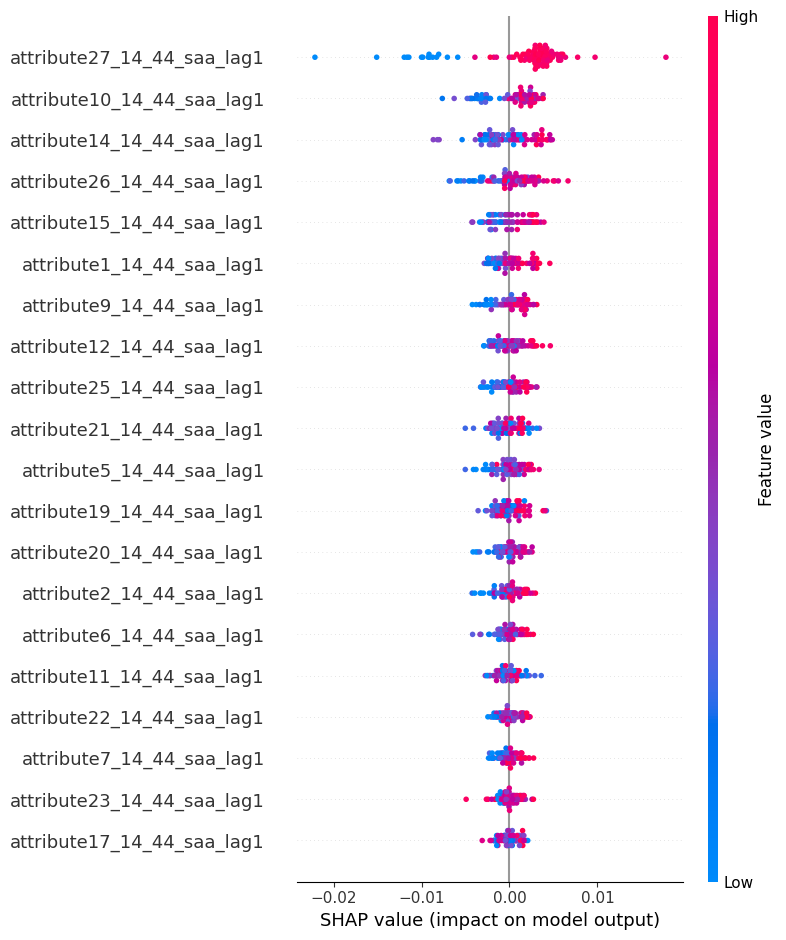

In [221]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X)

# Визуализация SHAP значений
shap.summary_plot(shap_values, X)

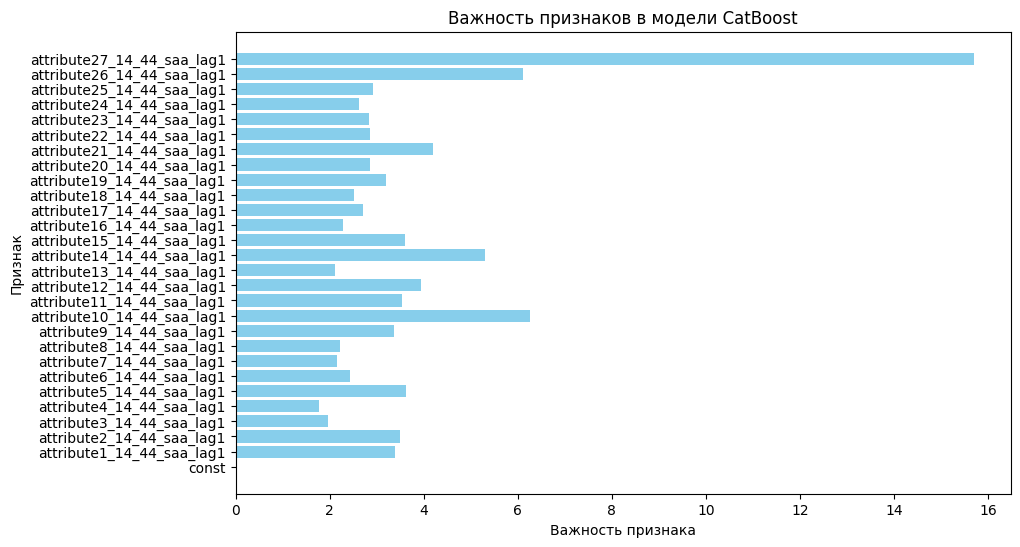

In [223]:
# Получение важности признаков
feature_importance = model.get_feature_importance(data=catboost.Pool(X, label=y))

# Создание графика важности признаков
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importance, color='skyblue')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков в модели CatBoost')
plt.show()

#### lag2

In [224]:
target = 'aa_prompted_percent_14_44'
model_factors = attributes_lag2
y = main_df[target]
X = sm.add_constant(main_df[model_factors])
# Обучение модели CatBoost
model = CatBoostRegressor(iterations=10000, depth=12, learning_rate=0.01)
model.fit(X, y,verbose=False)
catbost_pred = model.predict(X)

In [225]:
catbost_pred = pd.Series(catbost_pred,index = y.index)

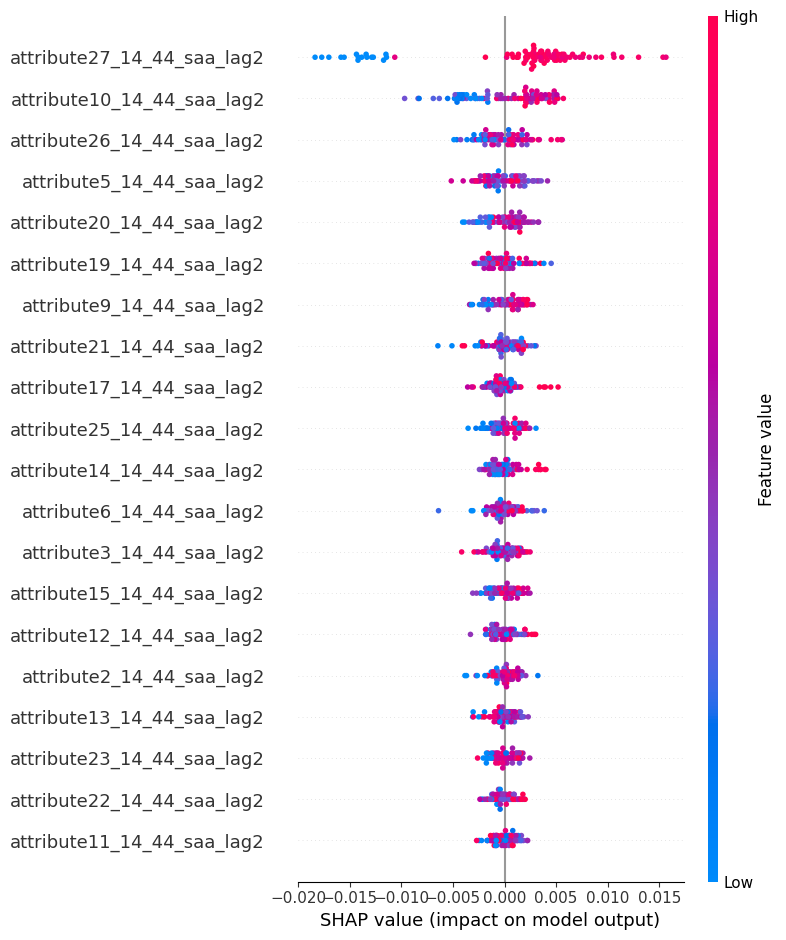

In [226]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X)

# Визуализация SHAP значений
shap.summary_plot(shap_values, X)

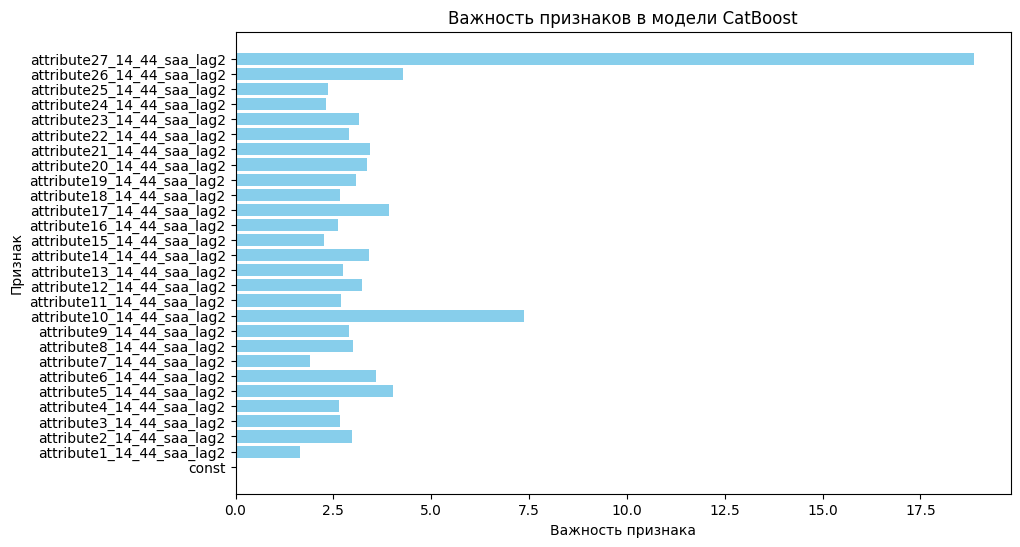

In [227]:
# Получение важности признаков
feature_importance = model.get_feature_importance(data=catboost.Pool(X, label=y))

# Создание графика важности признаков
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importance, color='skyblue')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков в модели CatBoost')
plt.show()

### ba_promp

#### lag1

In [228]:
target = 'ba_prompted_percent_14_44'
model_factors = attributes_lag1
y = main_df[target]
X = sm.add_constant(main_df[model_factors])
# Обучение модели CatBoost
model = CatBoostRegressor(iterations=10000, depth=12, learning_rate=0.01)
model.fit(X, y,verbose=False)
catbost_pred = model.predict(X)

In [229]:
catbost_pred = pd.Series(catbost_pred,index = y.index)

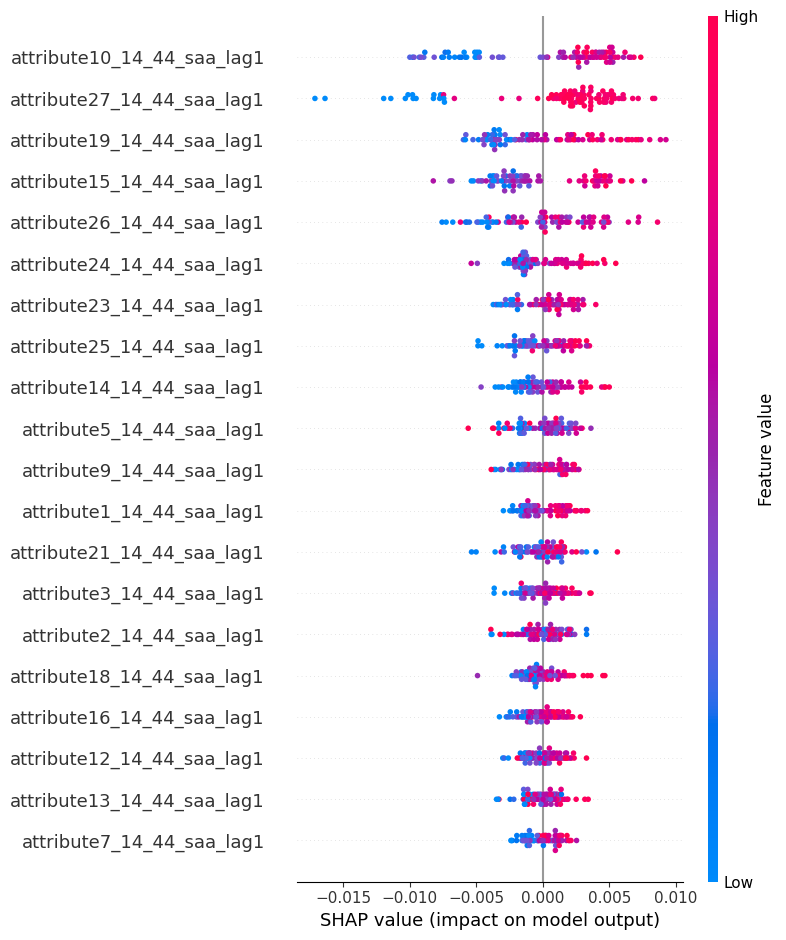

In [230]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X)

# Визуализация SHAP значений
shap.summary_plot(shap_values, X)

In [ ]:
# Получение важности признаков
feature_importance = model.get_feature_importance(data=catboost.Pool(X, label=y))

# Создание графика важности признаков
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importance, color='skyblue')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков в модели CatBoost')
plt.show()

#### lag2

In [231]:
target = 'ba_prompted_percent_14_44'
model_factors = attributes_lag2
y = main_df[target]
X = sm.add_constant(main_df[model_factors])
# Обучение модели CatBoost
model = CatBoostRegressor(iterations=10000, depth=12, learning_rate=0.01)
model.fit(X, y,verbose=False)
catbost_pred = model.predict(X)

In [232]:
catbost_pred = pd.Series(catbost_pred,index = y.index)

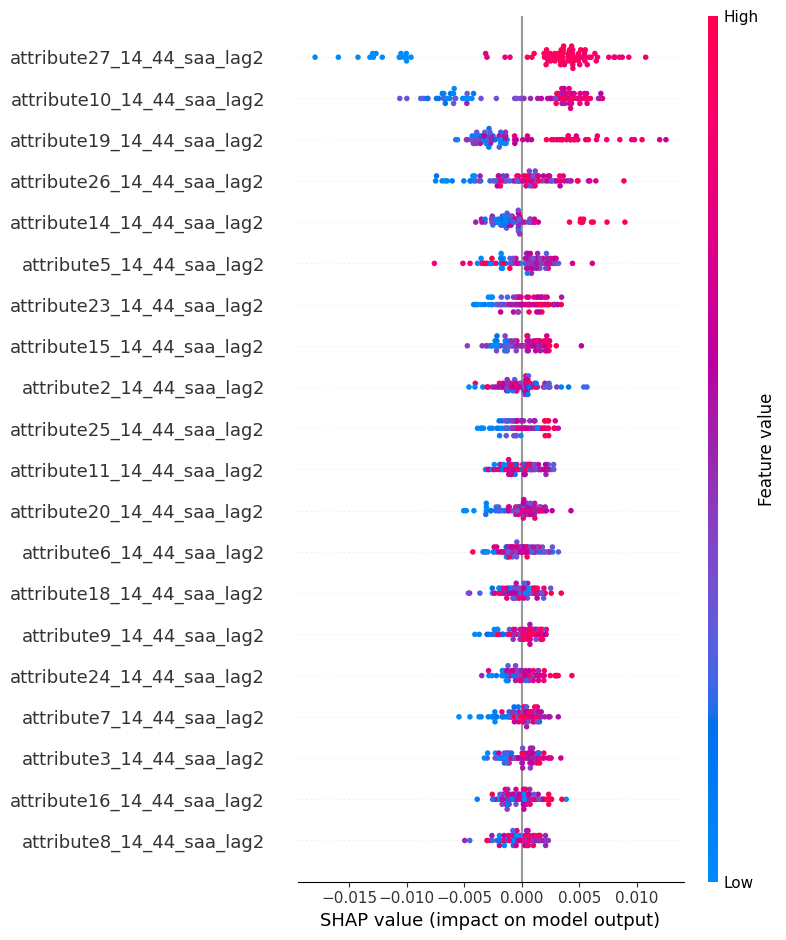

In [233]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X)

# Визуализация SHAP значений
shap.summary_plot(shap_values, X)

In [ ]:
# Получение важности признаков
feature_importance = model.get_feature_importance(data=catboost.Pool(X, label=y))

# Создание графика важности признаков
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importance, color='skyblue')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков в модели CatBoost')
plt.show()

### sba

#### lag1

In [234]:
target = 'ba_spontaneous_percent_14_44'
model_factors = attributes_lag1
y = main_df[target]
X = sm.add_constant(main_df[model_factors])
# Обучение модели CatBoost
model = CatBoostRegressor(iterations=10000, depth=12, learning_rate=0.01)
model.fit(X, y,verbose=False)
catbost_pred = model.predict(X)

In [235]:
catbost_pred = pd.Series(catbost_pred,index = y.index)

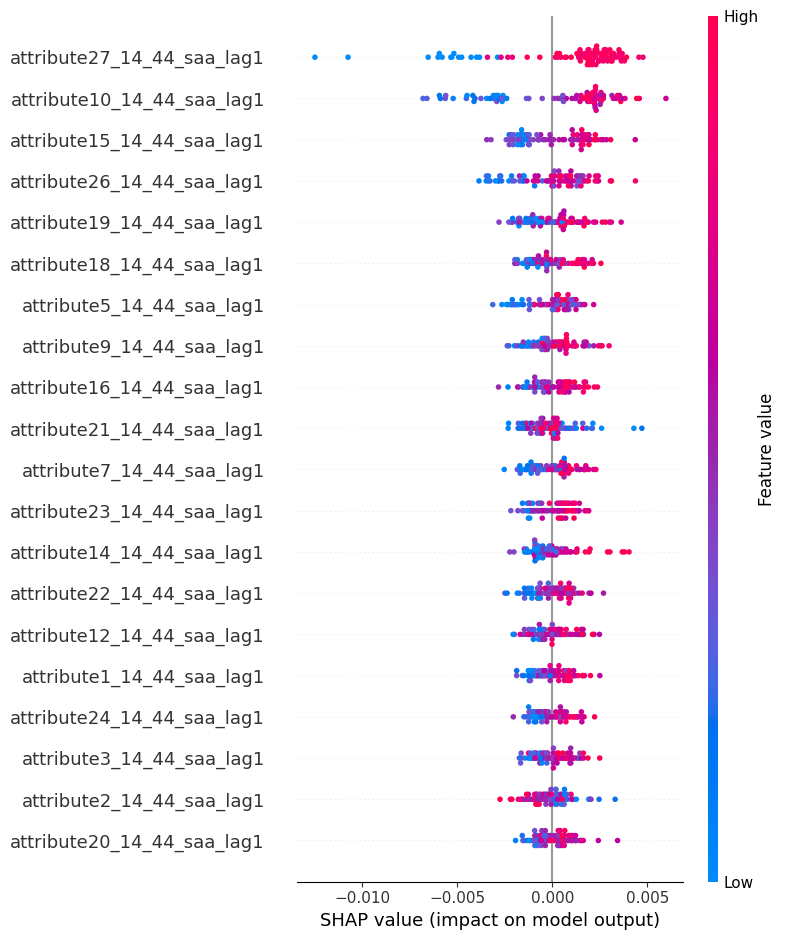

In [236]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X)

# Визуализация SHAP значений
shap.summary_plot(shap_values, X)

In [ ]:
# Получение важности признаков
feature_importance = model.get_feature_importance(data=catboost.Pool(X, label=y))

# Создание графика важности признаков
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importance, color='skyblue')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков в модели CatBoost')
plt.show()

#### lag2

In [237]:
target = 'ba_spontaneous_percent_14_44'
model_factors = attributes_lag2
y = main_df[target]
X = sm.add_constant(main_df[model_factors])
# Обучение модели CatBoost
model = CatBoostRegressor(iterations=10000, depth=12, learning_rate=0.01)
model.fit(X, y,verbose=False)
catbost_pred = model.predict(X)

In [238]:
catbost_pred = pd.Series(catbost_pred,index = y.index)

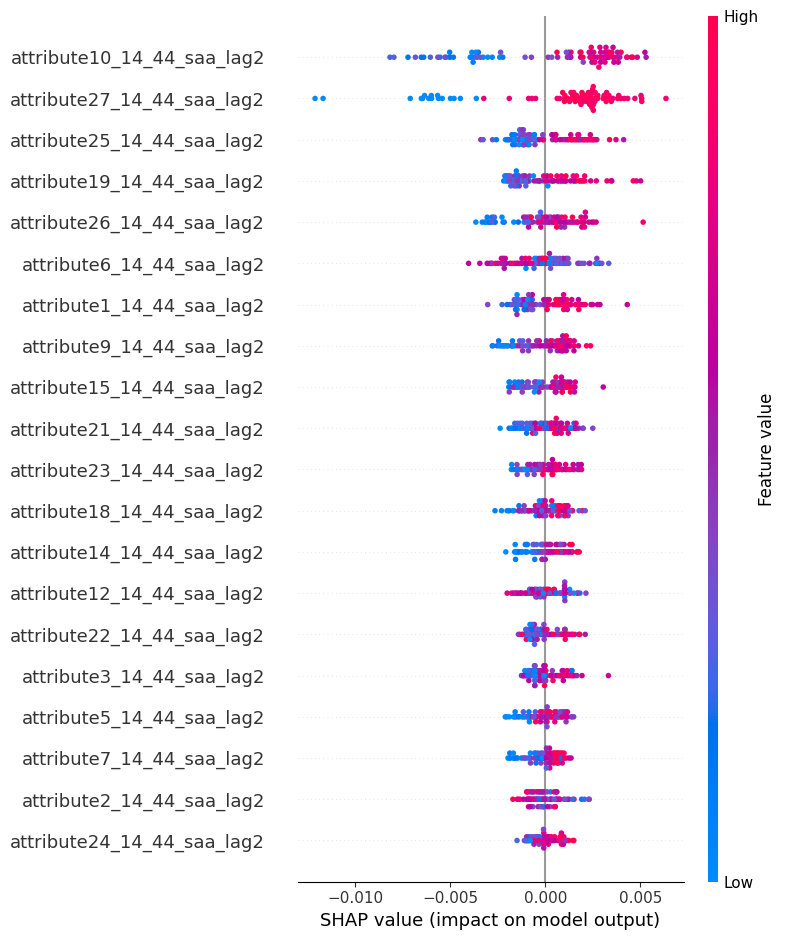

In [239]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X)

# Визуализация SHAP значений
shap.summary_plot(shap_values, X)

### consid

#### lag1

In [240]:
target = 'consid_percent_14_44'
model_factors = attributes_lag1
y = main_df[target]
X = sm.add_constant(main_df[model_factors])
# Обучение модели CatBoost
model = CatBoostRegressor(iterations=10000, depth=12, learning_rate=0.01)
model.fit(X, y,verbose=False)
catbost_pred = model.predict(X)

In [241]:
catbost_pred = pd.Series(catbost_pred,index = y.index)

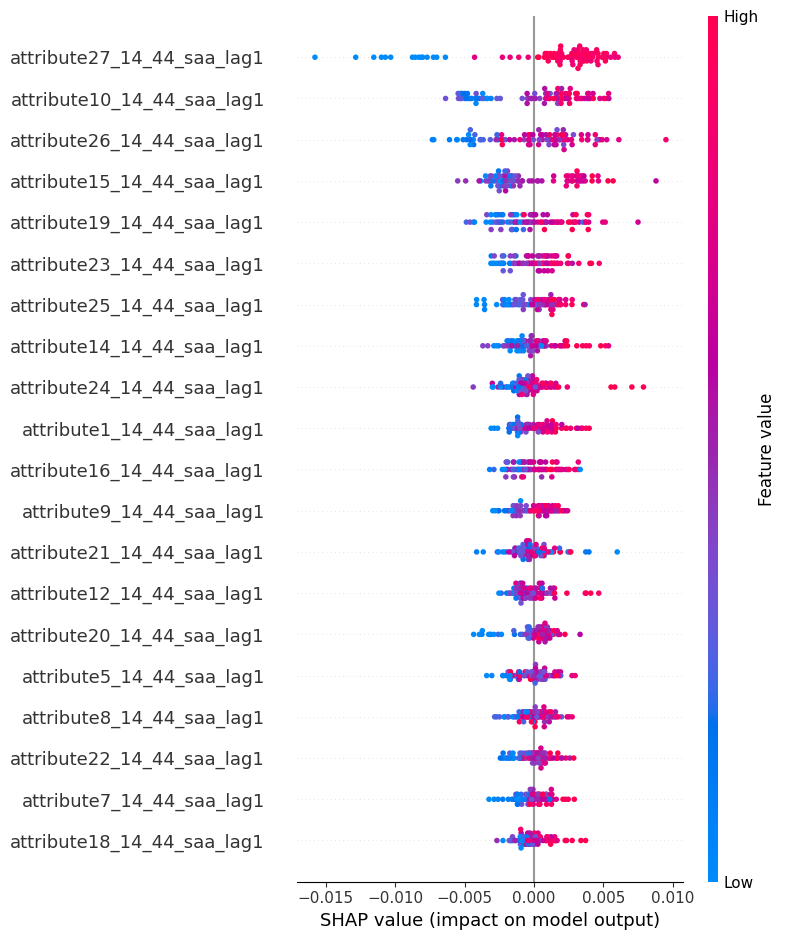

In [242]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X)

# Визуализация SHAP значений
shap.summary_plot(shap_values, X)

In [ ]:
# Получение важности признаков
feature_importance = model.get_feature_importance(data=catboost.Pool(X, label=y))

# Создание графика важности признаков
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importance, color='skyblue')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков в модели CatBoost')
plt.show()

#### lag2

In [243]:
target = 'consid_percent_14_44'
model_factors = attributes_lag2
y = main_df[target]
X = sm.add_constant(main_df[model_factors])
# Обучение модели CatBoost
model = CatBoostRegressor(iterations=10000, depth=12, learning_rate=0.01)
model.fit(X, y,verbose=False)
catbost_pred = model.predict(X)

In [244]:
catbost_pred = pd.Series(catbost_pred,index = y.index)

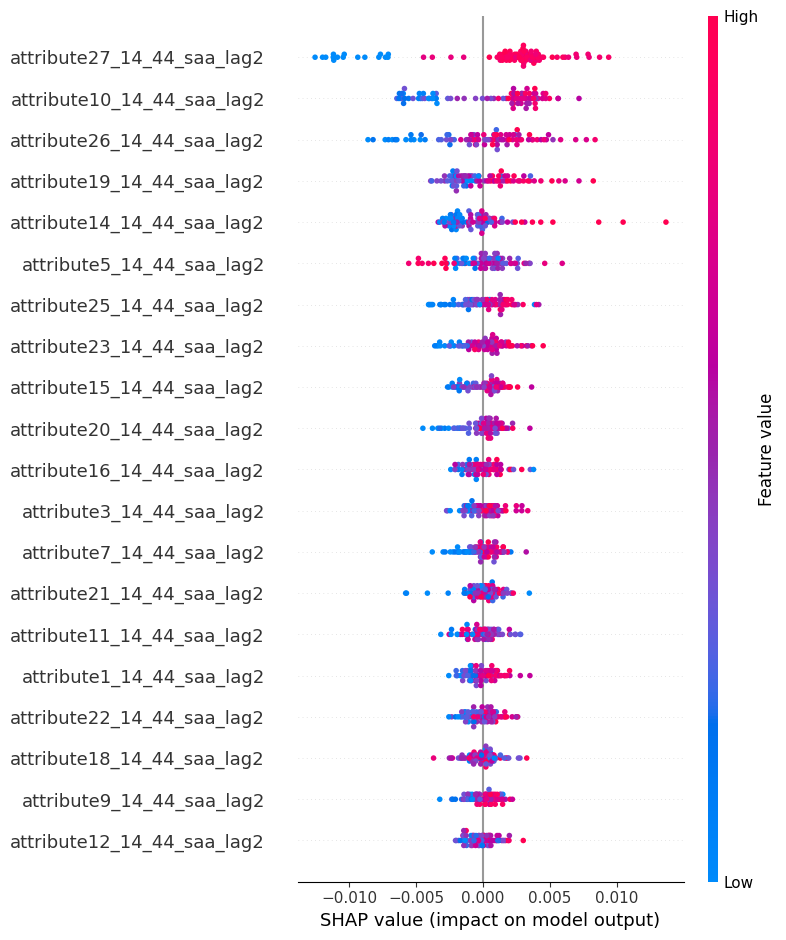

In [245]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X)

# Визуализация SHAP значений
shap.summary_plot(shap_values, X)

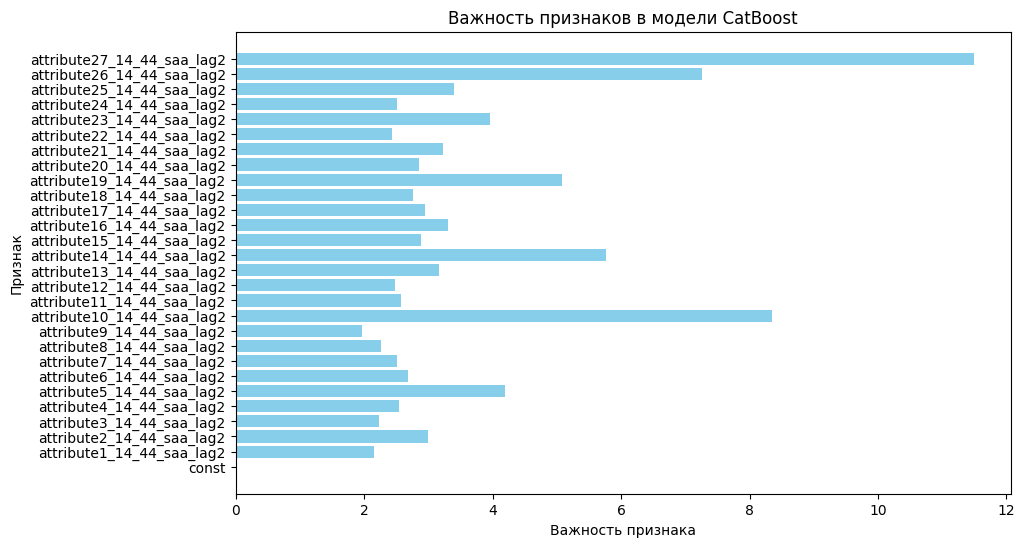

In [249]:
# Получение важности признаков
feature_importance = model.get_feature_importance(data=catboost.Pool(X, label=y))

# Создание графика важности признаков
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importance, color='skyblue')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков в модели CatBoost')
plt.show()

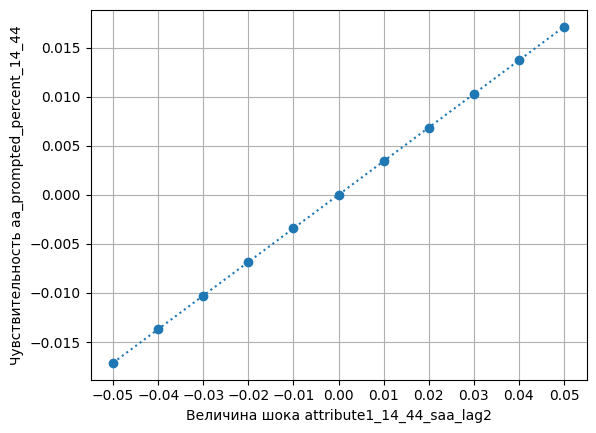

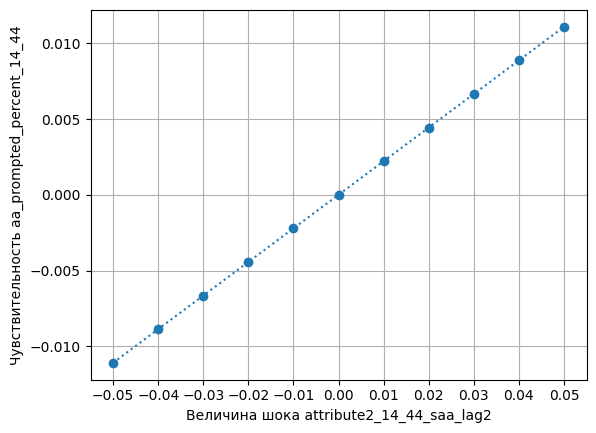

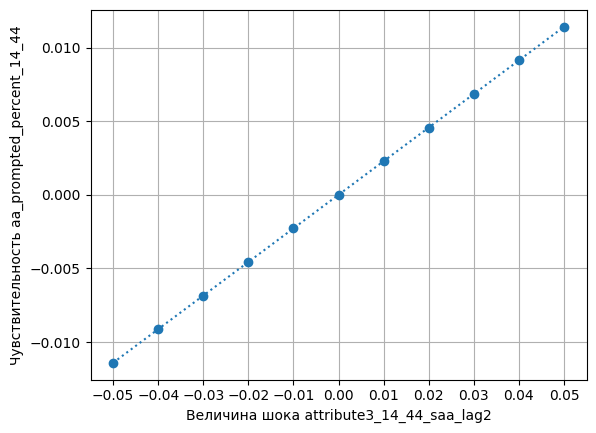

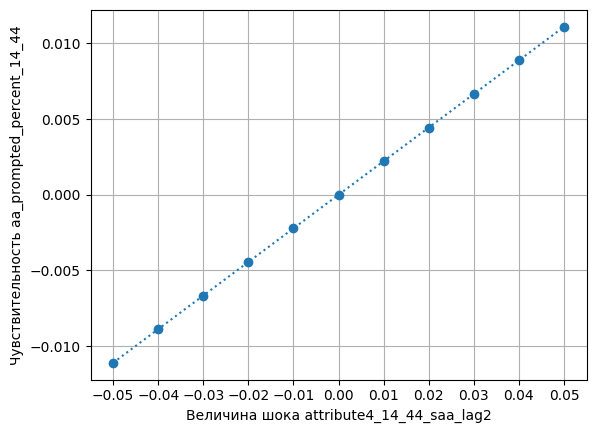

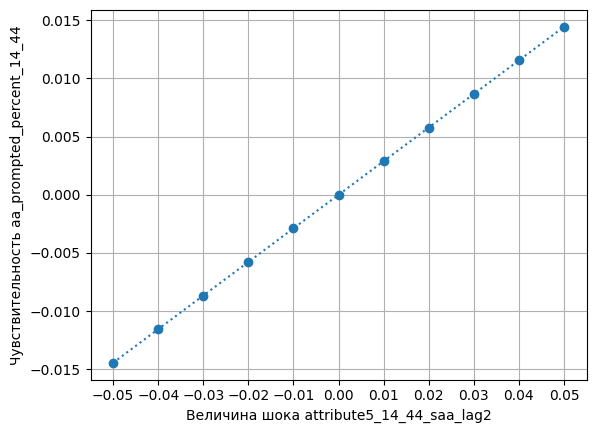

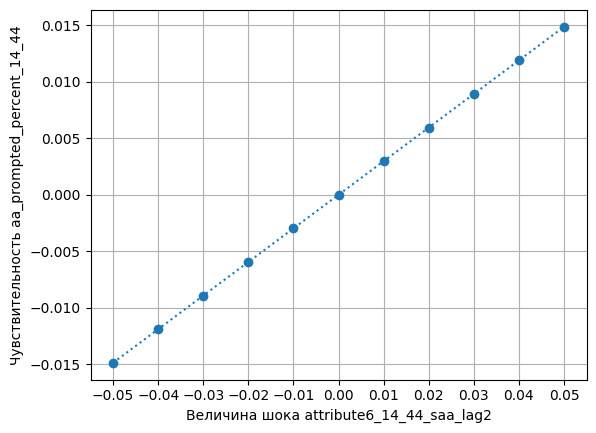

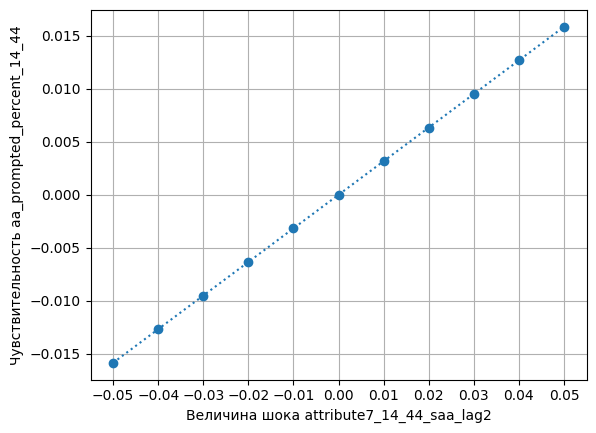

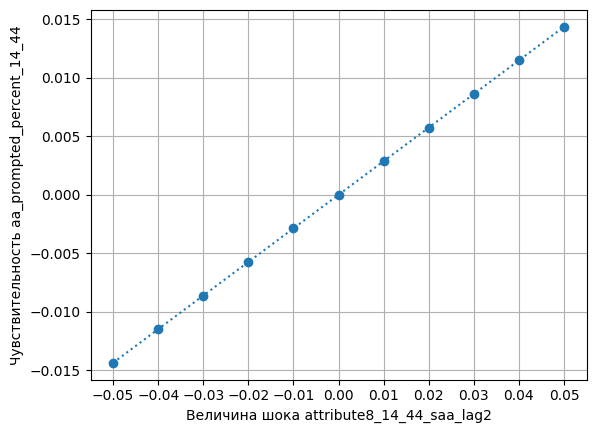

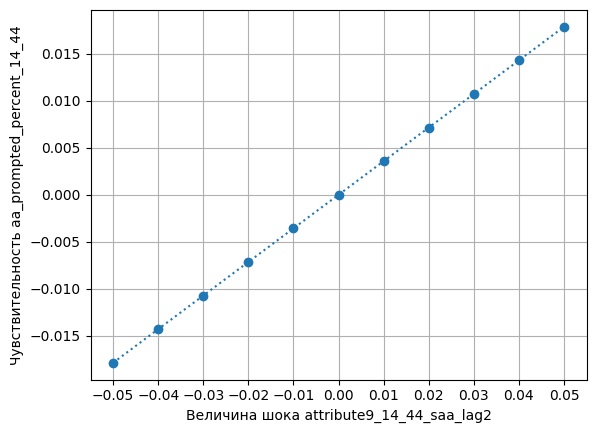

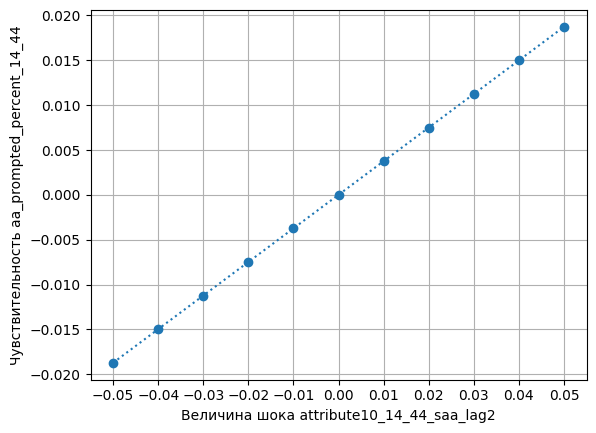

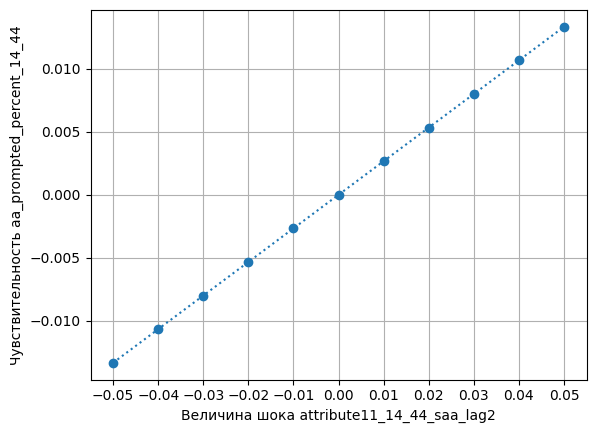

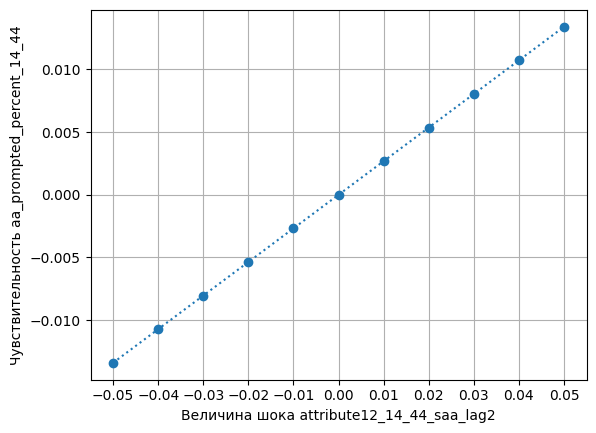

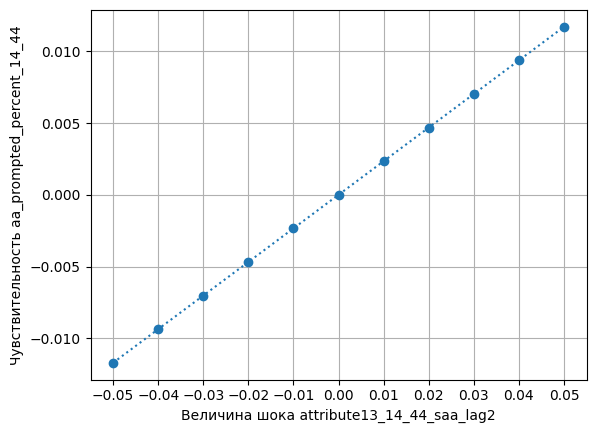

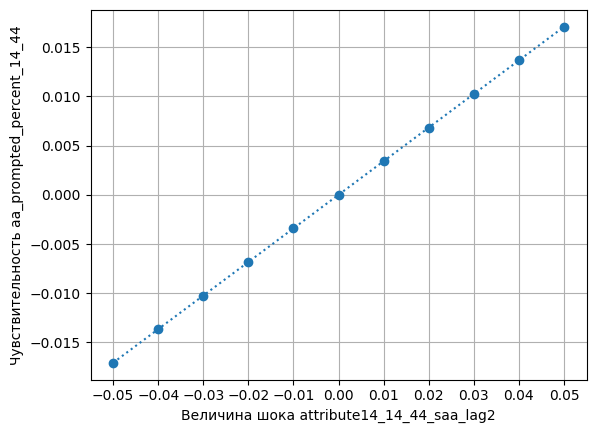

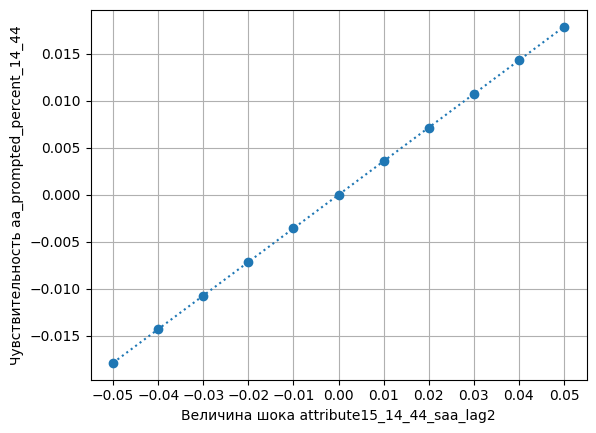

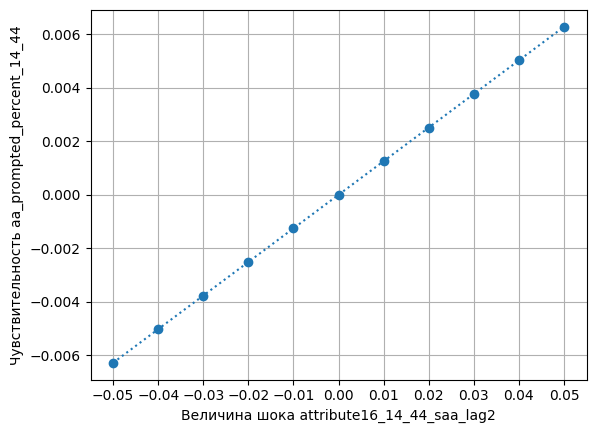

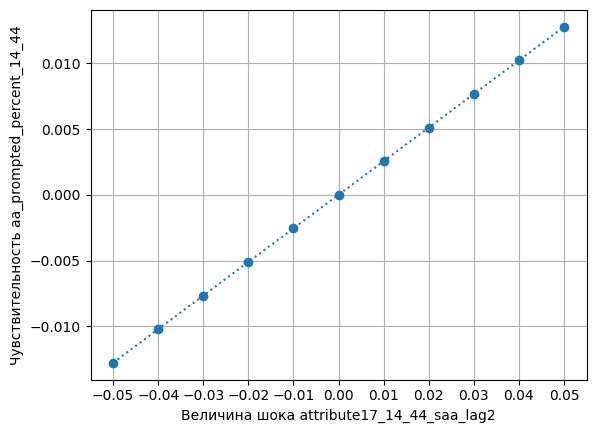

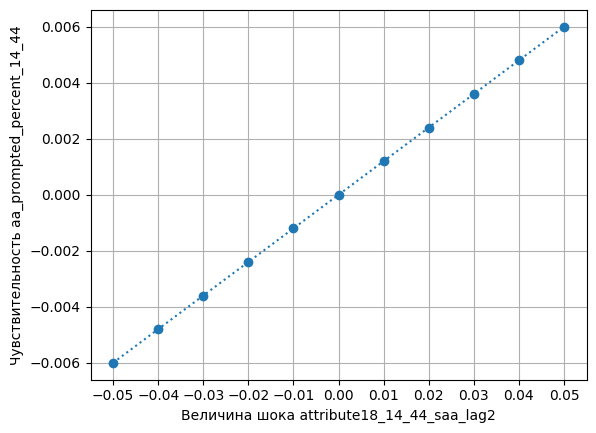

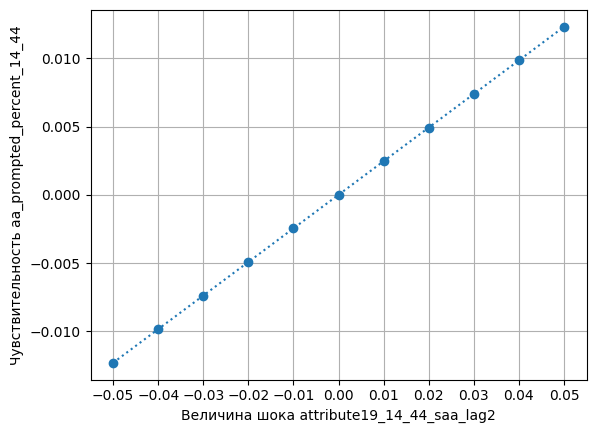

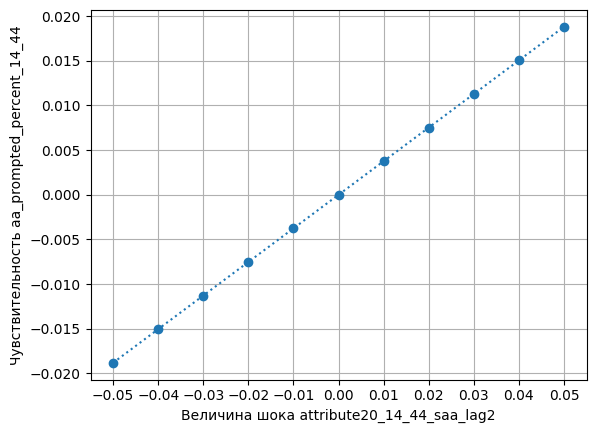

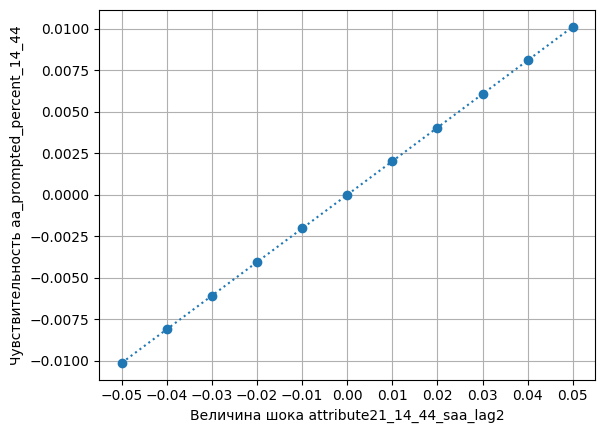

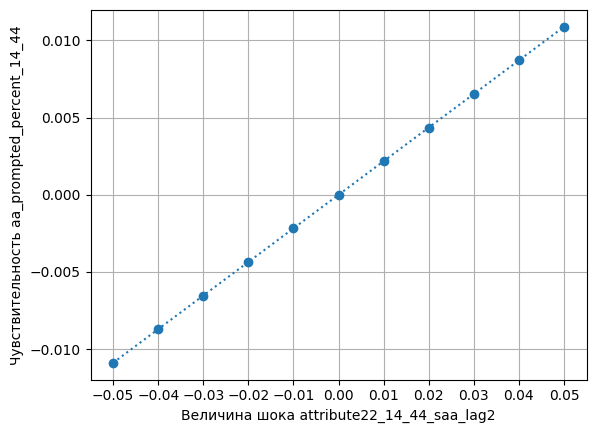

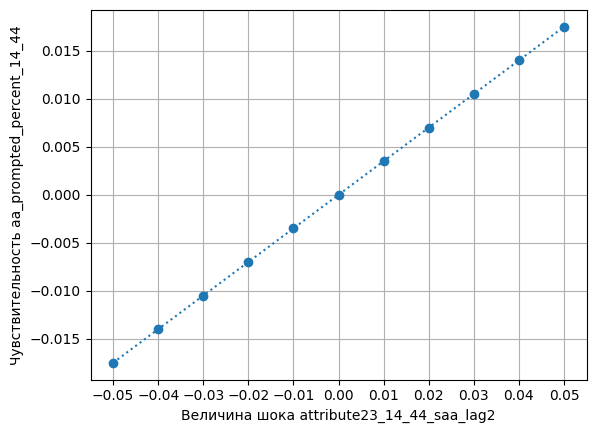

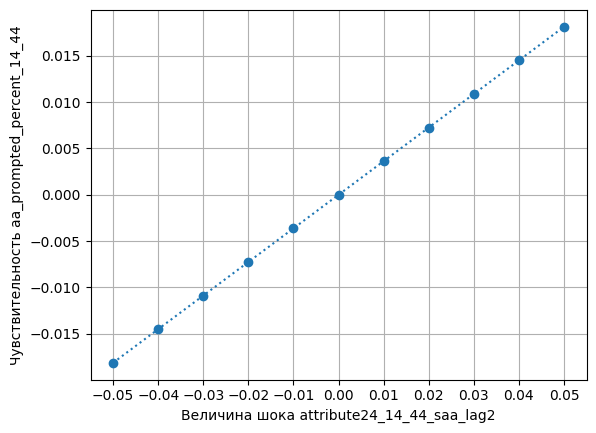

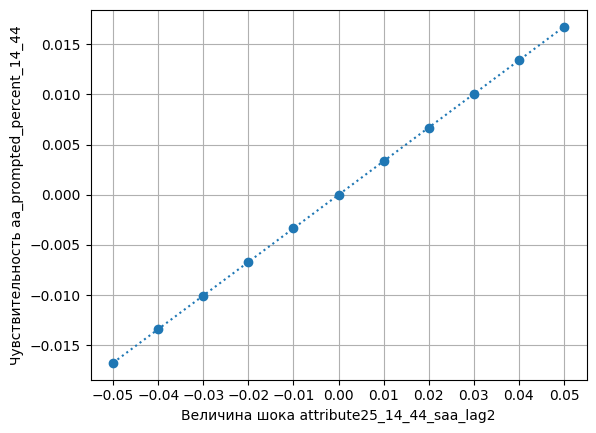

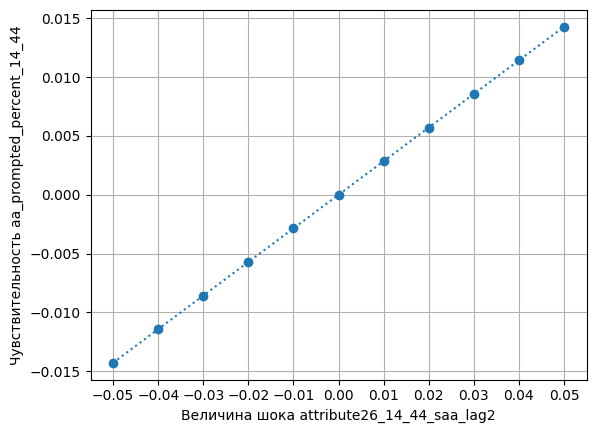

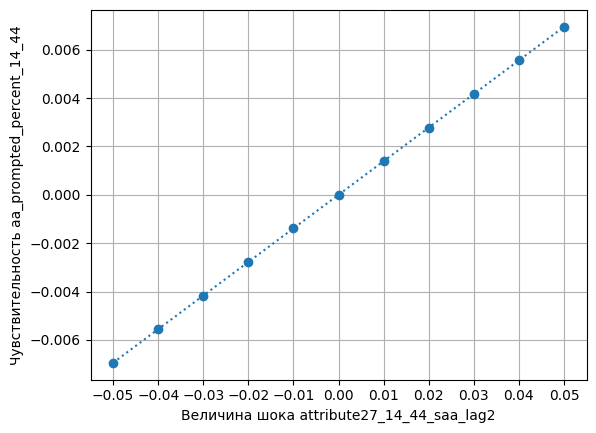

,-0.050,-0.040,-0.030,-0.020,-0.010,0.000,0.010,0.020,0.030,0.040,0.050
attribute1_14_44_saa_lag2,-0.017,-0.014,-0.010,-0.007,-0.003,0.000,0.003,0.007,0.010,0.014,0.017
attribute2_14_44_saa_lag2,-0.011,-0.009,-0.007,-0.004,-0.002,0.000,0.002,0.004,0.007,0.009,0.011
attribute3_14_44_saa_lag2,-0.011,-0.009,-0.007,-0.005,-0.002,0.000,0.002,0.005,0.007,0.009,0.011
attribute4_14_44_saa_lag2,-0.011,-0.009,-0.007,-0.004,-0.002,0.000,0.002,0.004,0.007,0.009,0.011
attribute5_14_44_saa_lag2,-0.014,-0.012,-0.009,-0.006,-0.003,0.000,0.003,0.006,0.009,0.012,0.014
attribute6_14_44_saa_lag2,-0.015,-0.012,-0.009,-0.006,-0.003,0.000,0.003,0.006,0.009,0.012,0.015
attribute7_14_44_saa_lag2,-0.016,-0.013,-0.010,-0.006,-0.003,0.000,0.003,0.006,0.010,0.013,0.016
attribute8_14_44_saa_lag2,-0.014,-0.011,-0.009,-0.006,-0.003,0.000,0.003,0.006,0.009,0.011,0.014
attribute9_14_44_saa_lag2,-0.018,-0.014,-0.011,-0.007,-0.004,0.000,0.004,0.007,0.011,0.014,0.018
attribute10_14_44_saa_lag2,-0.019,-0.015,-0.011,-0.007,-0.004,0.000,0.004,0.007,0.011,0.015,0.019


,attribute1_14_44_saa_lag2,attribute2_14_44_saa_lag2,attribute3_14_44_saa_lag2,attribute4_14_44_saa_lag2,attribute5_14_44_saa_lag2,attribute6_14_44_saa_lag2,attribute7_14_44_saa_lag2,attribute8_14_44_saa_lag2,attribute9_14_44_saa_lag2,attribute10_14_44_saa_lag2,...,attribute18_14_44_saa_lag2,attribute19_14_44_saa_lag2,attribute20_14_44_saa_lag2,attribute21_14_44_saa_lag2,attribute22_14_44_saa_lag2,attribute23_14_44_saa_lag2,attribute24_14_44_saa_lag2,attribute25_14_44_saa_lag2,attribute26_14_44_saa_lag2,attribute27_14_44_saa_lag2
-0.050,-0.017,-0.011,-0.011,-0.011,-0.014,-0.015,-0.016,-0.014,-0.018,-0.019,...,-0.006,-0.012,-0.019,-0.010,-0.011,-0.017,-0.018,-0.017,-0.014,-0.007
-0.040,-0.014,-0.009,-0.009,-0.009,-0.012,-0.012,-0.013,-0.011,-0.014,-0.015,...,-0.005,-0.010,-0.015,-0.008,-0.009,-0.014,-0.014,-0.013,-0.011,-0.006
-0.030,-0.010,-0.007,-0.007,-0.007,-0.009,-0.009,-0.010,-0.009,-0.011,-0.011,...,-0.004,-0.007,-0.011,-0.006,-0.007,-0.010,-0.011,-0.010,-0.009,-0.004
-0.020,-0.007,-0.004,-0.005,-0.004,-0.006,-0.006,-0.006,-0.006,-0.007,-0.007,...,-0.002,-0.005,-0.008,-0.004,-0.004,-0.007,-0.007,-0.007,-0.006,-0.003
-0.010,-0.003,-0.002,-0.002,-0.002,-0.003,-0.003,-0.003,-0.003,-0.004,-0.004,...,-0.001,-0.002,-0.004,-0.002,-0.002,-0.003,-0.004,-0.003,-0.003,-0.001
0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
0.010,0.003,0.002,0.002,0.002,0.003,0.003,0.003,0.003,0.004,0.004,...,0.001,0.002,0.004,0.002,0.002,0.003,0.004,0.003,0.003,0.001
0.020,0.007,0.004,0.005,0.004,0.006,0.006,0.006,0.006,0.007,0.007,...,0.002,0.005,0.008,0.004,0.004,0.007,0.007,0.007,0.006,0.003
0.030,0.010,0.007,0.007,0.007,0.009,0.009,0.010,0.009,0.011,0.011,...,0.004,0.007,0.011,0.006,0.007,0.010,0.011,0.010,0.009,0.004
0.040,0.014,0.009,0.009,0.009,0.012,0.012,0.013,0.011,0.014,0.015,...,0.005,0.010,0.015,0.008,0.009,0.014,0.014,0.013,0.011,0.006


In [254]:
calc_sens(main_df,kpi = 'aa_prompted_percent_14_44', 
          features_to_shock = attributes_lag2 )